<a href="https://colab.research.google.com/github/cmaddis/ai4dd/blob/main/lab2/lab2_module.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interventional experiments in cells

*Large scale cell painting assay visualizes effects of drugs and knockouts*

This notebook provides a comprehensive introduction to **phenomics**  using high-content cell painting data. You will analyze morphological changes in cells caused by genetic perturbations and small molecule treatments.

Many of the small molecules profiled have been selected because they are FDA approved, and known to be bioactive. Some may be inhibitors of key processes, and for these we might expect applying them to "phenocopy" the effects of a genetic knockout of a gene critical for that same process.

Rxrx3 represents a small public fraction of the total dataset generated by the pharma company Recursion.

## Overview
1. Pre-module
    * **Setup & Data Loading**: Environment configuration and RxRx3 dataset access
    * **Data Exploration**: Visualizing cell painting images and experimental metadata
    * **Featurization**: Computing pre-trained vision transformer embeddings
2. Module
    * **Batch Effect Correction**: Demo for removing technical artifacts
    * **Simpsons paradox**: Careful how you group your data
    * **Your team compound**: Each team is assigned a compound to investigate
3. Post-Module
    * **Single-cell Feature Extraction**: ScaleFEx for single-cell analysis


### Assignment questions are indicated with a block quote like this:
> 1. Answer this question!

### Expand "Show code" buttons to see details
In some places, code has been hidden to reduce visual clutter. You can look into the details of some custom functions we've provided by expanding these code blocks. Feel free to ask AI to explain any provided code you don't understand.

# Pre-module: featurization and embeddings



## Background: Cell Painting Assay
**Cell painting** is a high-content screening method that uses fluorescent dyes to visualize multiple cellular components simultaneously. This assay captures morphological changes in cells caused by genetic or chemical perturbations.

RxRx3 phenomics cell painting data: high-content screening of cells grown in wells, and flouresently tagged for 6 channels of major cell structures. This allows measurement of morphological effects of perturbations. Two types of perturbation have been tested: gene knockouts and small mollecule treatments.

### 6 fluorescent channels targeting different cellular structures:
  - **Nuclei** (DNA): Hoechst stain
  - **Endoplasmic reticulum**: Concanavalin A
  - **Nucleoli & cytoplasmic RNA**: SYTO 14
  - **Golgi & plasma membrane**: Wheat germ agglutinin  
  - **Mitochondria**: MitoTracker
  - **Actin cytoskeleton**: Phalloidin

### Experimental Design:
- **HUVEC cells**: Human umbilical vein endothelial cells
- **Perturbations**: CRISPR/Cas9 gene knockouts + small molecule treatments
- **High-throughput**: 222,601 wells across multiple experiments
- **Quantitative readout**: Morphological features extracted from images

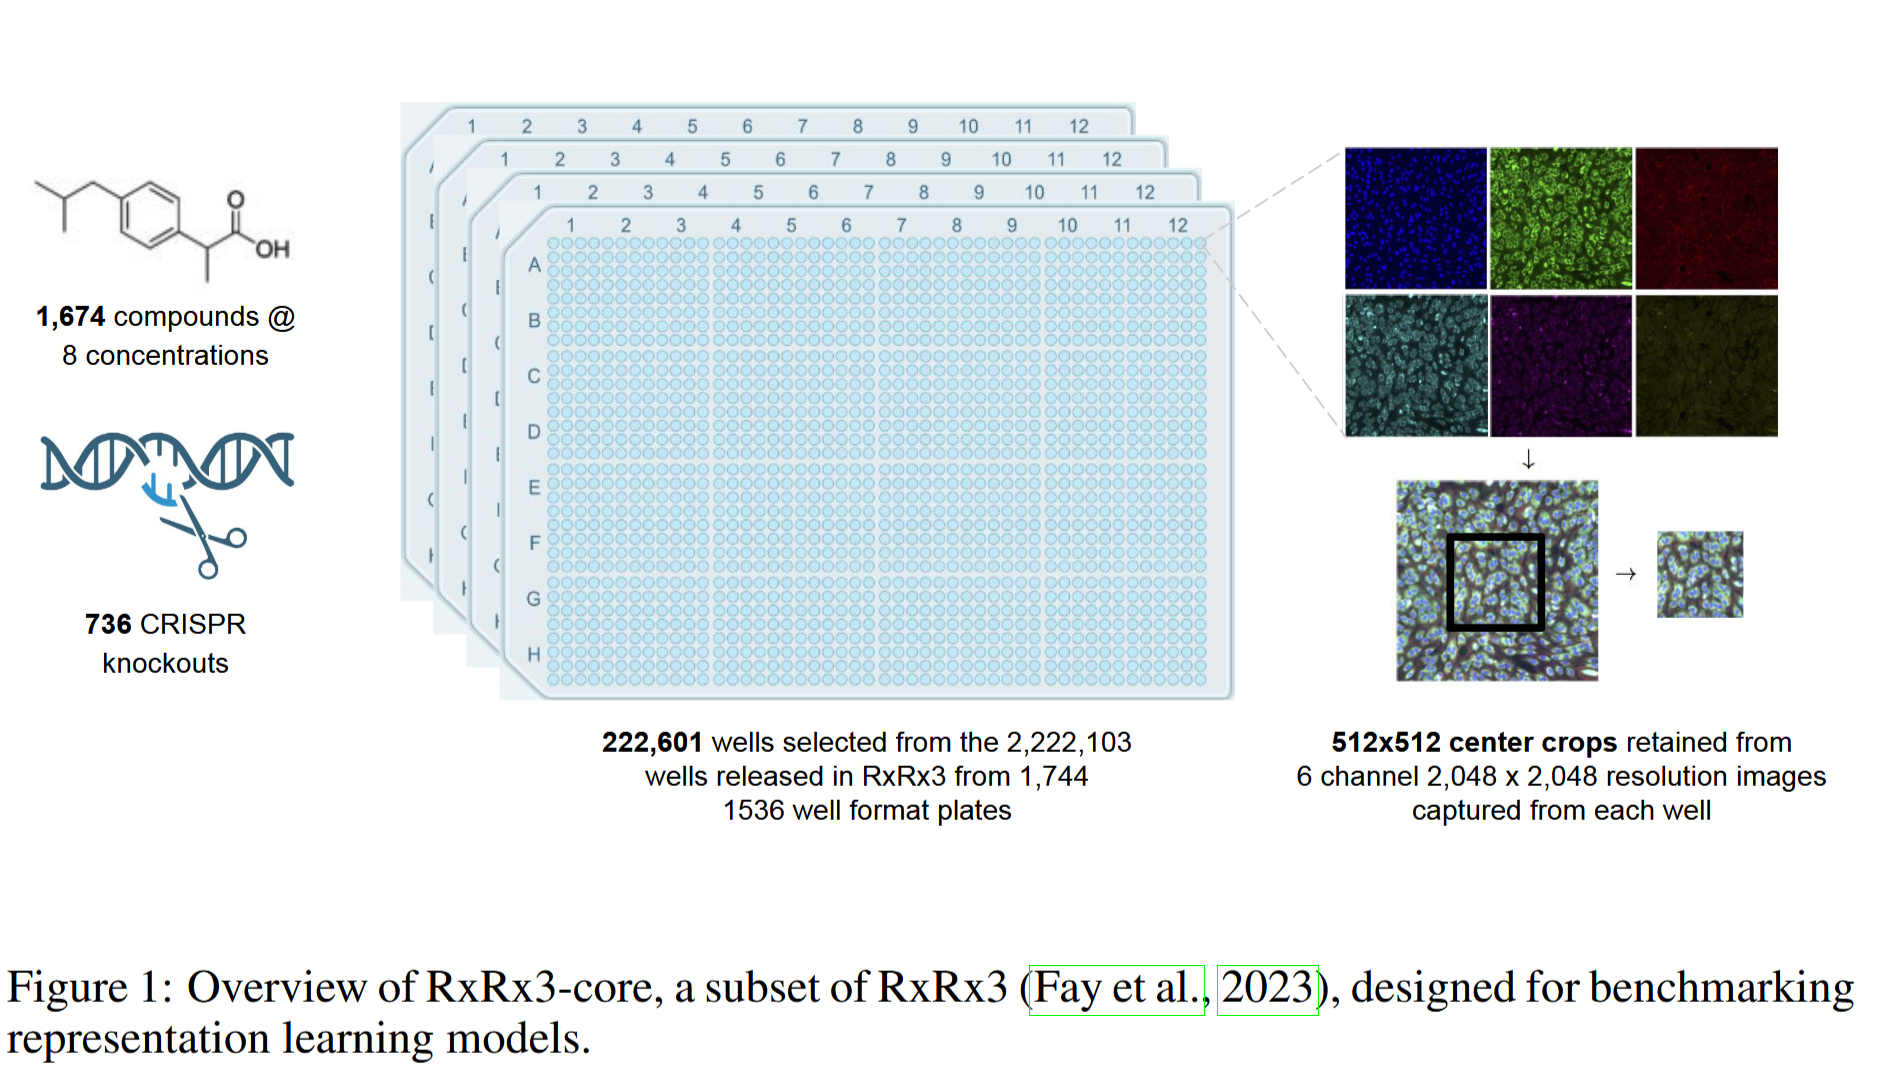

In this premodule, we will focus on the OpenPhenom model, and corresponding RxRx3 dataset which it was trained on.

### Recommended reading:

* [**Seal et al. 2024** Cell Painting review](https://www.nature.com/articles/s41592-024-02528-8)
* [**Kraus et al. 2024** OpenPhenom paper describing the training of computer vision model](https://doi.org/10.48550/arXiv.2404.10242)

Bonus reading:
* [**Kraus et al. 2025** RxRx3-core paper describing the preparation of the ML-ready dataset RxRx3](https://arxiv.org/pdf/2503.20158)
* [**Celik et al. 2024** Example application of using OpenPhenom embeddings to identify similarities between knockouts of genes involved in the same pathways](https://doi.org/10.1371/journal.pcbi.1012463)


### Requirements:

We're using the [Polaris platform](https://polarishub.io/), which provides efficient access to the rxrx3 dataset. You will need to create a Polaris account to continue.

In [1]:
# @title Set up

# @markdown load libraries for data analysis and plotting

%%capture
!git clone https://github.com/NYSCF/ScaleFEx.git
!pip install polaris-lib[codecs]==0.12.0 mahotas umap-learn geomloss
!GIT_LFS_SKIP_SMUDGE=1 git clone https://huggingface.co/recursionpharma/OpenPhenom

import warnings
import numpy as np
import pandas as pd
import polaris as po
import seaborn as sns
import skimage as ski
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy import stats, ndimage
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA
from polaris.hub.client import PolarisHubClient
from sklearn.metrics.pairwise import pairwise_distances


In [2]:
# For premodule: change your runtime type if the following is not True
import torch
cuda_available = torch.cuda.is_available()
print(cuda_available)

True


In [ ]:
client = PolarisHubClient()
client.login()

In [ ]:
# Load the dataset from the Hub
dataset = po.load_dataset("recursion/rxrx3-core")

## Look at the data


**Dataset Overview**: Examine the structure and contents of the RxRx3-core dataset. See [Polaris documentation](https://polaris-hub.github.io/polaris/stable/api/dataset.html) to learn more about the dataset class and available methods.

In [5]:
dataset

{
  "name": "RxRx3-core",
  "description": "To accompany OpenPhenom-S/16, Recursion is releasing the RxRx3-core dataset, a challenge dataset in phenomics optimized for the research community. RxRx3-core includes labeled images of 735 genetic knockouts and 1,674 small-molecule perturbations drawn from the RxRx3 dataset, image embeddings computed with OpenPhenom-S/16, and associations between the included small molecules and genes. The dataset contains 6-channel Cell Painting images and associated embeddings from 222,601 wells but is less than 18Gb, making it incredibly accessible to the research community.",
  "tags": [
    "phemomics",
    "perturbation",
    "gene",
    "compound"
  ],
  "user_attributes": {
    "Wells": "222,601",
    "Cell line": "HUVEC",
    "Gene perturbation": "CRISPR/Cas9-mediated gene knockouts",
    "Treatment perturbation": "Compound at 8 concentrations each"
  },
  "owner": "recursion",
  "polaris_version": "0.9.4.dev9+gbc2588b.d20241208",
  "slug": "rxrx3-core",
  "default_adapters": {},
  "zarr_root_path": "polarisfs://polaris/dataset/recursion/rxrx3-core/data.zarr",
  "readme": "![Recursion logo](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSgn5ii7g2UEVORKDmzzR0BKwzGr8Arz2ecTg&s)\n\n# RxRx3-core\n\n![Microscopy image](https://media.nature.com/lw1200/magazine-assets/d41573-019-00144-2/d41573-019-00144-2_17068016.jpg)\n\nTo accompany [OpenPhenom-S/16](https://www.rxrx.ai/phenom), Recursion is releasing the RxRx3-core dataset, a challenge dataset in phenomics optimized for the research community. RxRx3-core includes labeled images of 735 genetic knockouts and 1,674 small-molecule perturbations drawn from the [RxRx3 dataset](https://www.rxrx.ai/rxrx3) and image embeddings computed with  [OpenPhenom-S/16](https://www.rxrx.ai/phenom). The dataset contains 6-channel Cell Painting images and associated embeddings from 222,601 wells but is less than 18Gb, making it incredibly accessible to the research community.\n\nMapping the mechanisms by which drugs exert their actions is an important challenge in advancing the use of high-dimensional biological data like phenomics. We are excited to release the first dataset of this scale probing concentration-response along with [a benchmark](https://polarishub.io/benchmarks/recursion/rxrx-compound-gene-activity-benchmark) and model to enable the research community to rapidly advance this space.\n\nPaper published at LMRL Workshop at ICLR 2025: [RxRx3-core: Benchmarking drug-target interactions in High-Content Microscopy](https://arxiv.org/abs/2503.20158).\n\n## Building Maps of Biology and Chemistry\n\nAt Recursion, we build maps of biology and chemistry to explore uncharted areas of disease biology, unravel its complexity, and industrialize drug discovery. Just as a map helps to navigate the physical world, our maps are designed to help us understand as much as we can about the connectedness of human biology so we can navigate the path to new medicines more efficiently.\n\nOur maps are built using image-based high-dimensional data generated in-house. We conduct up to 2.2 million experiments every week in our highly automated labs, where we use deep learning models to embed high dimensional representations of billions of images of human cells that have been manipulated by CRISPR/Cas9-mediated gene knockouts, compounds, or other reagents. This allows us to create representations that can be compared and contrasted to predict trillions of relationships across biology and chemistry \u2014 even without physically testing all of the possible combinations. Recursion's Maps and associated applications help navigate complex biology and chemistry by revealing relationships across genes and chemical compounds.\n\n### Map Benchmarking\nTest your maps with the [`rxrx-compound-gene-activity-benchmark`](https://polarishub.io/benchmarks/recursion/rxrx-compound-gene-activity-benchmark) benchmark!\n",
  "annotations": {
    "gene": {
      "is_pointer": false,
      "modal

Each row in this dataset corresponds to an image of cells. You can access the image directly, precomputed OpenPhenom embeddings, or the associated metadata which details the experimental conditions.

In [6]:
dataset.columns

['SMILES',
 'address',
 'cell_type',
 'concentration',
 'embedding',
 'experiment_name',
 'gene',
 'images',
 'perturbation_type',
 'plate',
 'treatment',
 'well_id']

In [7]:
# @title Data Preparation

# @markdown Set up metadata structures for convenient access, then examine representative cell painting images from the dataset.

zarr_root = dataset.zarr_data
zarr_root

def well_letters_to_number(letters):
    result = 0
    for char in letters:
        result = result * 26 + (ord(char) - ord('A') + 1)
    return result

metadata=pd.DataFrame({
    'treatment':zarr_root['treatment'][:] ,
    'experiment_name':zarr_root['experiment_name'][:] ,
    'concentration':zarr_root['concentration'][:] ,
    'plate': zarr_root['plate'][:] ,
    'address': zarr_root['address'][:]
})

metadata = metadata.reset_index(names=['dataset_index'])
metadata["experiment_type"] = metadata["experiment_name"].apply(lambda x: x.split("-")[0])
metadata["perturbation"] = metadata["treatment"].apply(lambda x: x.split("_")[0] if "_control" not in x else x)
metadata["is_empty_control"] = metadata['treatment'] == "EMPTY_control"
metadata['well_col'] = metadata['address'].str.extract(r'([0-9]+)').astype(int)
metadata['well_row'] = metadata['address'].str.extract(r'([A-Z]+)')[0].apply(well_letters_to_number)
metadata['concentration'] = pd.Categorical(
    metadata['concentration'].astype(str),
    categories = ['0.0025', '0.01', '0.025', '0.1', '0.25', '1.0', '2.5', '10.0'],
    ordered=True
)

# recode concentration to include gene experiments
metadata.loc[:, 'Dose'] = metadata['concentration'].astype(str)
metadata.loc[metadata['experiment_type'] == 'gene', 'Dose'] = 'Gene KO'
metadata.loc[metadata['perturbation'] == 'EMPTY_control', 'Dose'] = 'EMPTY_control'
metadata['Dose'] = pd.Categorical(
    metadata['Dose'],
    categories=['EMPTY_control', 'Gene KO', '0.0025', '0.01', '0.025', '0.1', '0.25', '1.0', '2.5', '10.0'],
    ordered=True
)

In [8]:
metadata

dataset_index        treatment experiment_name concentration  plate  \
0                   0        Phloretin    compound-003         0.025     11   
1                   1        Clozapine    compound-003           2.5     35   
2                   2      Dequalinium    compound-001          0.25     19   
3                   3    EMPTY_control    compound-001           NaN     11   
4                   4   CRISPR_control    compound-004           NaN     43   
...               ...              ...             ...           ...    ...   
222596         222596    EMPTY_control        gene-176           NaN      9   
222597         222597     PEX6_guide_2        gene-176           NaN      6   
222598         222598    ACAA2_guide_4        gene-176           NaN      8   
222599         222599      FBL_guide_5        gene-176           NaN      4   
222600         222600  RPS6KB1_guide_4        gene-176           NaN      1   

       address experiment_type    perturbation  is_empty_control  well_col  \
0         AD37        compound       Phloretin             False        37   
1          Y15        compound       Clozapine             False        15   
2          D20        compound     Dequalinium             False        20   
3          U08        compound   EMPTY_control              True         8   
4          B08        compound  CRISPR_control             False         8   
...        ...             ...             ...               ...       ...   
222596     B09            gene   EMPTY_control              True         9   
222597     T13            gene            PEX6             False        13   
222598     I27            gene           ACAA2             False        27   
222599     C35            gene             FBL             False        35   
222600     P42            gene         RPS6KB1             False        42   

        well_row           Dose  
0             30          0.025  
1             25            2.5  
2              4           0.25  
3             21  EMPTY_control  
4              2            NaN  
...          ...            ...  
222596         2  EMPTY_control  
222597        20        Gene KO  
222598         9        Gene KO  
222599         3        Gene KO  
222600        16        Gene KO  

[222601 rows x 12 columns]

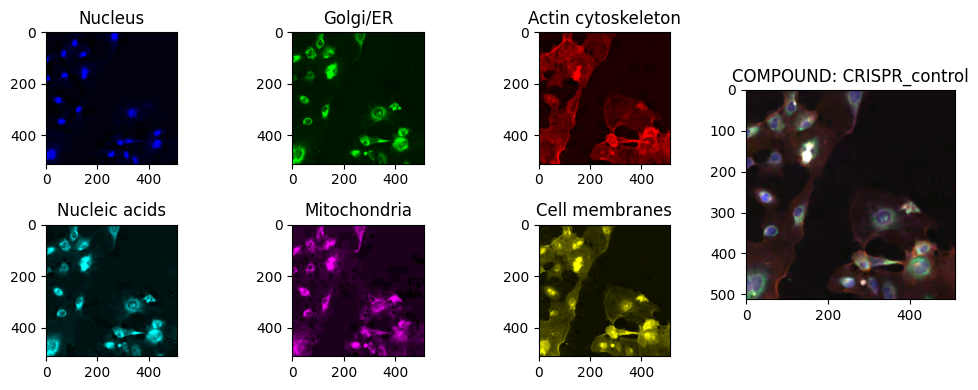

In [9]:
# @title Each image is a small, square crop from the middle of the well containing six channels, each staining for a particular structure.
# @markdown | Channel | Colour | Structure | Stain |
# @markdown |-------|--------|-----------|-------|
# @markdown | 0 | Blue | Nucleus | Hoechst 33342 |
# @markdown | 1 | Lime | Golgi apparatus and ER | Concanavalin A |
# @markdown | 2 | Red | Actin cytoskeleton | Phalloidin |
# @markdown | 3 | Cyan | Nucleic acids (DNA & RNA)| Syto14 |
# @markdown | 4 | Magenta | Mitochondria | MitoTracker |
# @markdown | 5 | Yellow | Cell membranes | Agglutinin |
# @markdown
# @markdown
# @markdown Pick an image to visualize (number between 0 and 222601). Change the number below to check out a few different images.
image_number = 100 #@param {type:"number"}

# some plotting functions
def create_black_to_color_cmap(colour_name, colour_value):
    c_range = ['black', colour_value]
    return mcolors.LinearSegmentedColormap.from_list(colour_name, c_range)

def make_composite(img, exposure=1, colours = np.array([[0,0,1], [0,1,0], [1,0,0], [0,1,1], [1,0,1], [1,1,0]])):
    n_channels, h, w = img.shape
    composite = np.zeros((h, w, 3))
    for i in range(n_channels):
        channel_norm = (img[i,:,:] - img[i,:,:].min()) / ((img[i,:,:].max() - img[i,:,:].min()) + 1e-5)
        composite += (channel_norm * exposure)[:,:,None] * colours[i]
    composite = np.clip(composite, 0, 1)
    return composite

# display image
def show_dataset_image(dataset_index):

    channel_names = ['Nucleus', 'Golgi/ER',  'Actin cytoskeleton', 'Nucleic acids', 'Mitochondria', 'Cell membranes']
    pal = ['blue', 'lime', 'red', 'cyan', 'magenta', 'yellow']

    # plot cell painting
    fig = plt.figure(figsize=(10, 4))
    gs = gridspec.GridSpec(2, 4, figure=fig)

    img = dataset.get_data(row=dataset_index, col='images').T # Change the row rumber to see a different image
    n_channels, h, w = img.shape

    # Create composite
    composite = make_composite(img,)

    # Plot channels
    for row in range(2):
        for col in range(3):
            ch_idx = row * 3 + col
            ax = fig.add_subplot(gs[row, col])
            ax.imshow(img[ch_idx,:,:], cmap=create_black_to_color_cmap('black_to_color', pal[ch_idx]), vmax=np.percentile(img[ch_idx,:,:], 99))
            ax.set_title(f'{channel_names[ch_idx]}')

    # Plot composite spanning both rows in rightmost column
    ax_comp = fig.add_subplot(gs[:, 3])
    ax_comp.imshow(composite)


    if ~np.isnan(dataset.get_data(row=dataset_index, col='concentration')):
        title = dataset.get_data(row=dataset_index, col='perturbation_type') + ': ' + dataset.get_data(row=dataset_index, col='treatment') + " (" +  dataset.get_data(row=dataset_index, col='concentration').astype(str) + "um)"
    else:
        title = dataset.get_data(row=dataset_index, col='perturbation_type') + ': ' + dataset.get_data(row=dataset_index, col='treatment')

    ax_comp.set_title(title)

    plt.tight_layout()
    plt.show()

show_dataset_image(image_number)

COMPOUND: Ractopamine


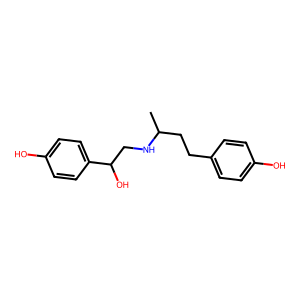

In [10]:
from rdkit import Chem

# @title Each compound has a SMILES representation of its structure
# @markdown Pick an image to visualize compound applied (number between 0 and 222601). Change the number below to check out a few different compounds. Note that not all images are associated with a compound, if they are from an empty control or genetic knockout sample.
image_number = 40 #@param {type:"number"}
m_smile = dataset.get_data(row=image_number, col='SMILES')

if m_smile == '':
  print('Perturbation does not involve a compound')

print(dataset.get_data(row=image_number, col='perturbation_type') + ': ' + dataset.get_data(row=image_number, col='treatment'))
m_mol = Chem.MolFromSmiles(m_smile)
Chem.Draw.MolToImage(m_mol)

## Featurization with a pre-trained vision transformer

OpenPenom is a model developed to do whole-image embedding of cell painting data, trained on the RxRx3 data. This section will show an example of how to calculate a 384-feature embedding vector to represent the image as a whole.

First, the image is cut into quadrants, and passed in as four 256x256 patches. Then, a size-384 embedding is calculated for each patch. To represent the image as a whole, these embeddings are averaged.

### Work with your team to answer the following:

>1. Why are patches size 256x256?
>1. What is an appropriate metric to use to calculate distances in this embedding space? Justify your answer in one sentence.  
>1. What kind of changes to cell phenotype are possible to detect with a cell painting assay?
>1. What would you expect to happen to the embedding if only 20% of cells were affected by a treatment?
>1. Not all images have the same number of cells in them. Suggest one reason for this.

The next few code blocks are modified the [OpenPhenom example notebook](https://huggingface.co/recursionpharma/OpenPhenom/blob/main/RxRx3-core_inference.ipynb). This provides an example walk through of how an embedding vector is calculated from the pre-trained OpenPhenom model in inference mode. This section will not execute unless you have a GPU.

In [11]:
# Change your runtime type if the following is not True
print(cuda_available)

True


In [ ]:
from torch.utils.data import DataLoader
from OpenPhenom.huggingface_mae import MAEModel

if cuda_available:
    open_phenom = MAEModel.from_pretrained("recursionpharma/OpenPhenom")
    open_phenom.eval()
    open_phenom.cuda()

In [13]:
def collate_batch(batch):
    # Extract images from Polaris dataset format
    images = np.stack([i['images'] for i in batch])  # Shape: (batch_size, 512, 512, 6)
    # Transpose to channel-first format for PyTorch: (batch_size, 6, 512, 512)
    images = np.transpose(images, (0, 3, 1, 2))
    # Convert to patches
    images = np.vstack([patch_image(i) for i in images])
    images = torch.from_numpy(images)
    # Extract other metadata if needed
    well_ids = [i.get('well_id', f'well_{idx}') for idx, i in enumerate(batch)]
    return images, well_ids

def iter_border_patches(width, height, patch_size):
    x_start, x_end, y_start, y_end = (0, width, 0, height)
    for x in range(x_start, x_end - patch_size + 1, patch_size):
        for y in range(y_start, y_end - patch_size + 1, patch_size):
            yield x, y

def patch_image(image_array, patch_size=256):
    _, width, height = image_array.shape
    output_patches = []
    patch_count = 0
    for x, y in iter_border_patches(width, height, patch_size):
        patch = image_array[:, y : y + patch_size, x : x + patch_size].copy()
        output_patches.append(patch)
    output_patches = np.stack(output_patches)
    return output_patches

In [14]:
# PyTorch DataLoader
batch_size = 5
num_workers = 2
rxrx3_core_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False,
                                   collate_fn=collate_batch, num_workers=num_workers)

In [16]:
num_features = 384
n_crops = 4
well_ids = []

emb_ind = 0
forward_pass_counter = 0
example_embeddings = np.zeros((len(rxrx3_core_dataloader.dataset), num_features), dtype=np.float32)

for imgs, batch_well_ids in rxrx3_core_dataloader:
    if not cuda_available:
        break
    if forward_pass_counter == 30:
      print('\nFor example purposes we won\'t compute all embeddings...')
      break # remove this to continue more forward passes
    # prediction loop
    if cuda_available:
        torch.cuda.empty_cache()
        with torch.amp.autocast("cuda"), torch.no_grad():
            latent = open_phenom.predict(imgs.cuda())
    else:
        latent = open_phenom.predict(imgs)
    latent = latent.view(-1, n_crops, num_features).mean(dim=1)  # average over 4 256x256 crops per image
    example_embeddings[emb_ind : (emb_ind + len(latent))] = latent.detach().cpu().numpy()
    well_ids.extend(batch_well_ids)
    emb_ind += len(latent)
    forward_pass_counter += 1
    if forward_pass_counter % 5 == 0:
        print(f"forward pass {forward_pass_counter} of {len(rxrx3_core_dataloader)} done, wells inferenced {emb_ind}")


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/instancenorm.py:115: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(


forward pass 5 of 44521 done, wells inferenced 25
forward pass 10 of 44521 done, wells inferenced 50
forward pass 15 of 44521 done, wells inferenced 75
forward pass 20 of 44521 done, wells inferenced 100
forward pass 25 of 44521 done, wells inferenced 125
forward pass 30 of 44521 done, wells inferenced 150

For example purposes we won't compute all embeddings...


In [17]:
print('Example embeddings shape:', example_embeddings[:emb_ind,:].shape)
example_embeddings[:emb_ind,:]

Example embeddings shape: (150, 384)


array([[ 0.05614521,  0.12966745,  0.02290706, ...,  0.0135722 ,
         0.14214094, -0.1155556 ],
       [ 0.05437439,  0.13145238,  0.03743128, ...,  0.00327311,
         0.14866136, -0.16420782],
       [ 0.06909771,  0.10303731,  0.05499844, ...,  0.03421136,
         0.16913062, -0.15902348],
       ...,
       [ 0.0993403 ,  0.08321358,  0.40564173, ...,  0.14750892,
         0.27407682, -0.20284536],
       [ 0.05223191,  0.11371462, -0.00171585, ..., -0.02190769,
         0.06865801, -0.09704927],
       [ 0.05251563,  0.10749891,  0.02048501, ...,  0.01863339,
         0.08994572, -0.18282047]], dtype=float32)

This small example has shown you how these embeddings were computed. Re-computing the embeddings for all 222601 wells would be slow, so we will instead make use of those conveinently pre-computed and provided by Polaris.

In [18]:
embeddings = zarr_root['embedding'][:]
print('Pre-computed OpenPhenom embeddings shape:', embeddings.shape)
embeddings

Pre-computed OpenPhenom embeddings shape: (222601, 384)


array([[ 0.03998568,  0.14960128, -0.04337039, ..., -0.07911311,
         0.17363086, -0.12858786],
       [ 0.04177235,  0.14312035, -0.03793113, ..., -0.09635396,
         0.1919498 , -0.20042607],
       [ 0.04882592,  0.12900269, -0.02803792, ..., -0.06513879,
         0.22908041, -0.17242387],
       ...,
       [ 0.0373543 ,  0.14472015,  0.03389354, ..., -0.09631862,
         0.16607949, -0.16197091],
       [ 0.05027398,  0.14328936, -0.02604963, ..., -0.01688828,
         0.17231807, -0.10266865],
       [ 0.0328906 ,  0.15161861, -0.03092021, ..., -0.10774013,
         0.16037266, -0.16642895]], dtype=float32)

We'll remove the CRISPR_control samples from the compound experiments, as we won't make use of these


In [19]:
embeddings = embeddings[metadata['perturbation'] != 'CRISPR_control']
metadata = metadata[metadata['perturbation'] != 'CRISPR_control']

Lastly, we can combine the metadata and embeddings into one dataframe

In [20]:
rxrx3 = pd.concat([metadata.reset_index(drop=True), pd.DataFrame(embeddings).rename(columns = lambda x: "openphenom_" + str(x))], axis=1)
embedding_cols = [col for col in rxrx3 if col.startswith('openphenom')]
metadata_cols = list(metadata.columns)

rxrx3

dataset_index        treatment experiment_name concentration  plate  \
0                   0        Phloretin    compound-003         0.025     11   
1                   1        Clozapine    compound-003           2.5     35   
2                   2      Dequalinium    compound-001          0.25     19   
3                   3    EMPTY_control    compound-001           NaN     11   
4                   5    AP2S1_guide_6        gene-032           NaN      7   
...               ...              ...             ...           ...    ...   
200534         222596    EMPTY_control        gene-176           NaN      9   
200535         222597     PEX6_guide_2        gene-176           NaN      6   
200536         222598    ACAA2_guide_4        gene-176           NaN      8   
200537         222599      FBL_guide_5        gene-176           NaN      4   
200538         222600  RPS6KB1_guide_4        gene-176           NaN      1   

       address experiment_type   perturbation  is_empty_control  well_col  \
0         AD37        compound      Phloretin             False        37   
1          Y15        compound      Clozapine             False        15   
2          D20        compound    Dequalinium             False        20   
3          U08        compound  EMPTY_control              True         8   
4          D27            gene          AP2S1             False        27   
...        ...             ...            ...               ...       ...   
200534     B09            gene  EMPTY_control              True         9   
200535     T13            gene           PEX6             False        13   
200536     I27            gene          ACAA2             False        27   
200537     C35            gene            FBL             False        35   
200538     P42            gene        RPS6KB1             False        42   

        ...  openphenom_374 openphenom_375  openphenom_376  openphenom_377  \
0       ...       -0.013445      -0.162979        0.054389       -0.069481   
1       ...        0.017443      -0.176950        0.068680       -0.112014   
2       ...        0.047074      -0.097213        0.044904       -0.060549   
3       ...        0.037430      -0.127650        0.081945       -0.103018   
4       ...        0.020081      -0.139442        0.125040       -0.127528   
...     ...             ...            ...             ...             ...   
200534  ...        0.004305      -0.149338        0.061101       -0.107559   
200535  ...        0.007846      -0.159604        0.081446       -0.104214   
200536  ...        0.024385      -0.157560        0.076072       -0.101269   
200537  ...       -0.051963      -0.126479        0.111598       -0.151676   
200538  ...        0.009448      -0.143318        0.082716       -0.113463   

        openphenom_378  openphenom_379  openphenom_380  openphenom_381  \
0            -0.124423        0.022028        0.022953       -0.079113   
1            -0.106931       -0.081489        0.027819       -0.096354   
2            -0.114342       -0.056257        0.036089       -0.065139   
3            -0.111236       -0.029558        0.063839       -0.089739   
4            -0.127948       -0.015811        0.070935       -0.084576   
...                ...             ...             ...             ...   
200534       -0.177293       -0.033122        0.017482       -0.077784   
200535       -0.137147        0.009453        0.071720       -0.085263   
200536       -0.144242        0.004941        0.092762       -0.096319   
200537       -0.088346       -0.074755        0.119485       -0.016888   
200538       -0.180223       -0.012474        0.063770       -0.107740   

        openphenom_382  openphenom_383  
0             0.173631       -0.128588  
1             0.191950       -0.200426  
2             0.229080       -0.172424  
3             0.177193       -0.133892  
4             0.151885       -0.126598  
...                ...             ...  
200534        0.18256

# Module


## Account for batch effects

### Background: Batch Effects in High-Content Screening
**Batch effects** are systematic technical variations that occur between different experimental runs, plates, or time points.

### Why Batch Correction Matters:
- Batch effects can **mask biological signals** of interest
- **Confound** treatment comparisons across different experiments
- Lead to **false discoveries** or missed biological insights
- Essential for **reproducible** and **interpretable** results

### Correction Strategy:
We use **center-scaling** within each batch to normalize the data while preserving biological variation.

### Before we start:  make a list of 3 possible sources of technical noise.

>1.  
>2.  
>3.  


## Batch correction

We'll fit PCA on the controls only, this way any new perturbation units can be added using the same transformation. By fitting PCA parameters on controls (which represent the unperturbed cellular state), we create a "baseline" that defines the principal components based on natural biological variation. This ensures that perturbation effects are measured relative to normal cellular variation and allows new experiments to be directly compared using the same transformation.

In [21]:
pca = PCA(10)
pca = pca.fit(rxrx3[embedding_cols][rxrx3['is_empty_control']==True]) # fit to controls
pcs = pca.transform(rxrx3[embedding_cols]) # apply to all samples
rxrx3['PC1'] = pcs[:,0]
rxrx3['PC2'] = pcs[:,1]


There are many more, smaller batches for the Gene KO experiments than compound experiments.

In [22]:
unique_experiment_counts = rxrx3.groupby('experiment_type')['experiment_name'].nunique()
print(unique_experiment_counts)

experiment_type
compound      4
gene        176
Name: experiment_name, dtype: int64


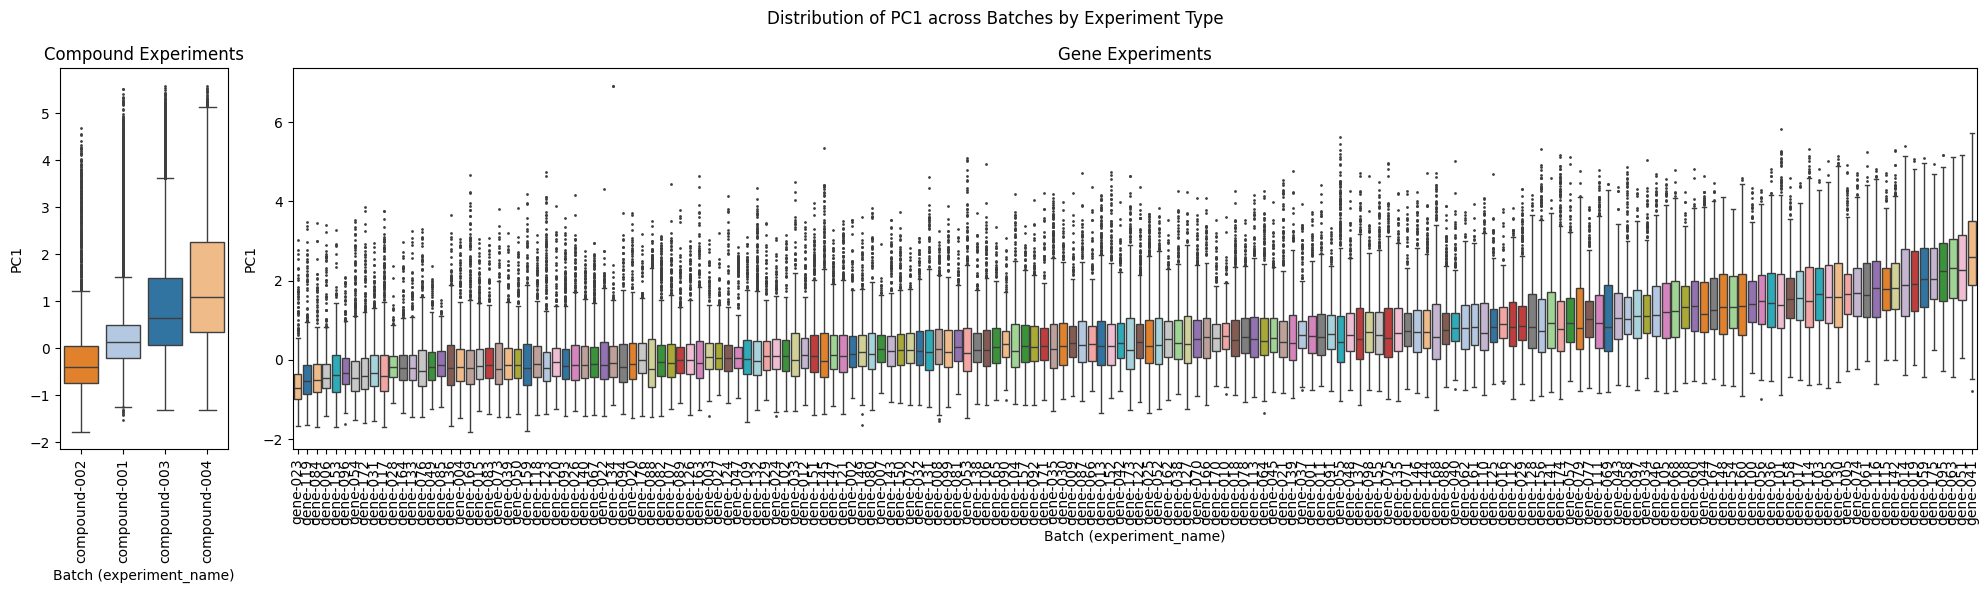

In [23]:
# @markdown These batches are not particularly aligned in PCA space, as you can see by their distribution of PC1 values

# Create subplots with different widths for gene vs compound experiments
fig, axes = plt.subplots(1,2, figsize=(20, 6), gridspec_kw={'width_ratios': [1, 10]})

for i, (exp_type, ax) in enumerate(zip(['compound', 'gene'], axes)):
    # Filter data for this experiment type
    data = rxrx3[rxrx3['experiment_type'] == exp_type]

    # Calculate mean PC1 for each experiment_name and sort
    means = data.groupby('experiment_name')['PC1'].mean().sort_values()
    order = means.index.tolist()

    # Create boxplot
    sns.boxplot(
        data=data,
        x='experiment_name',
        y='PC1',
        order=order,
        hue = 'experiment_name',
        palette='tab20',
        fliersize=1,
        legend=False,
        ax=ax
    )

    # Customize axes
    ax.set_xlabel('Batch (experiment_name)')
    ax.set_ylabel('PC1')
    ax.set_title(f'{exp_type.title()} Experiments')
    ax.tick_params(axis='x', rotation=90)

plt.suptitle('Distribution of PC1 across Batches by Experiment Type')
plt.tight_layout()
plt.show()

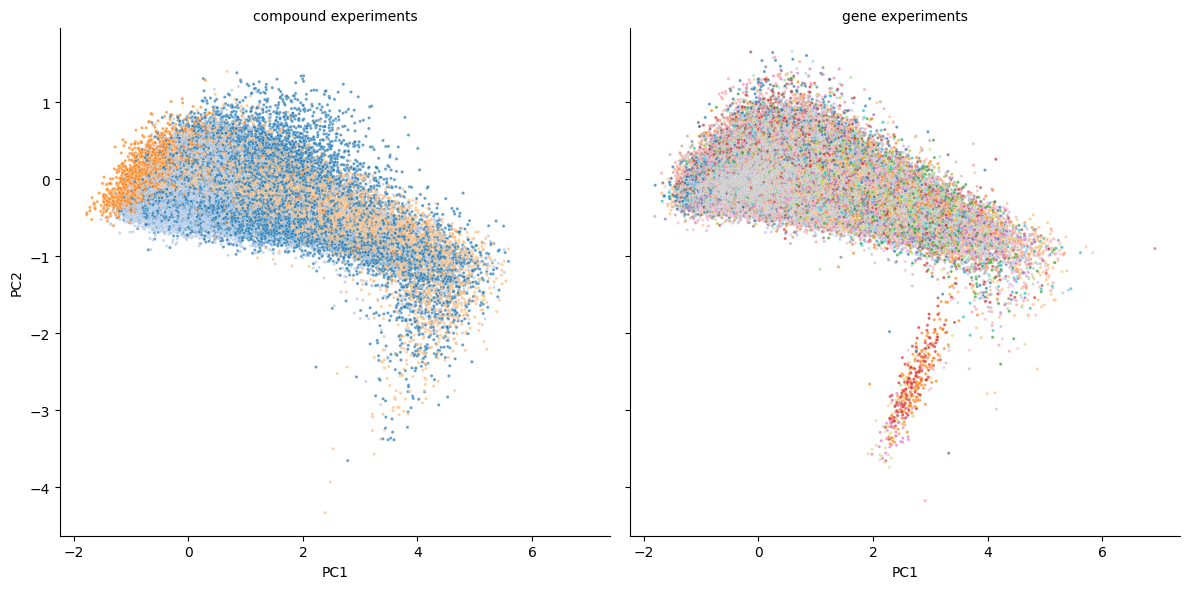

In [24]:
# @markdown And we can see this in 2D by plotting PC1 against PC2
g = sns.FacetGrid(
    rxrx3,
    col="experiment_type",
    sharex=True,
    sharey=True,
    height=6,
    aspect=1
)
g.map_dataframe(
    sns.scatterplot,
    x="PC1",
    y="PC2",
    hue="experiment_name",
    palette="tab20",
    s=5,
    alpha=0.7,
    legend=False
)
g.set_axis_labels("PC1", "PC2")
g.set_titles(col_template="{col_name} experiments")


plt.tight_layout()
plt.show()

There is a small group of outliers with `PC2 < -2` lets investigate these further. Look at the `dataset_index` column to select an image to view. Manually inspect these to get an intuition for what is different about these experiments

In [25]:
rxrx3[rxrx3['PC2'] < -2].sort_values('PC2')


dataset_index       treatment experiment_name concentration  plate  \
34924           40530    Flavopiridol    compound-004           2.5     20   
175632         197694   CAPN1_guide_6        gene-129           NaN      6   
56938           66154        GDC-0994    compound-004          0.25     44   
30150           35017   EMPTY_control        gene-088           NaN      2   
57390           66674   EMPTY_control        gene-088           NaN      2   
...               ...             ...             ...           ...    ...   
77995           90480    Cabozantinib    compound-003          10.0     24   
58116           67512        B-HT 920    compound-004         0.025     44   
7981             9285  INCB018424 (S)    compound-003           0.1     13   
3503             4057       Pramoxine    compound-003           1.0     13   
88490          102640    Voriconazole    compound-004         0.025     17   

       address experiment_type    perturbation  is_empty_control  well_col  \
34924      S20        compound    Flavopiridol             False        20   
175632     H42            gene           CAPN1             False        42   
56938      Q29        compound        GDC-0994             False        29   
30150      D40            gene   EMPTY_control              True        40   
57390     AB26            gene   EMPTY_control              True        26   
...        ...             ...             ...               ...       ...   
77995      J19        compound    Cabozantinib             False        19   
58116      O40        compound        B-HT 920             False        40   
7981       S39        compound  INCB018424 (S)             False        39   
3503       O06        compound       Pramoxine             False         6   
88490      V39        compound    Voriconazole             False        39   

        ...  openphenom_376 openphenom_377  openphenom_378  openphenom_379  \
34924   ...        0.332770      -0.181181        0.118260        0.030301   
175632  ...        0.199346      -0.208237        0.097181       -0.041628   
56938   ...        0.226833      -0.219248        0.122704       -0.040763   
30150   ...        0.296110      -0.135843        0.162108       -0.134196   
57390   ...        0.352041      -0.162110        0.194043       -0.143443   
...     ...             ...            ...             ...             ...   
77995   ...        0.050031      -0.347893       -0.104757        0.031604   
58116   ...        0.190222      -0.240722       -0.036590       -0.059509   
7981    ...        0.031544      -0.283343       -0.086271       -0.034292   
3503    ...        0.047289      -0.329250       -0.095986        0.006545   
88490   ...        0.119293      -0.307206       -0.008643       -0.054339   

        openphenom_380  openphenom_381  openphenom_382  openphenom_383  \
34924         0.165822       -0.135552        1.132582       -0.251049   
175632        0.334263       -0.116961        1.009468       -0.367914   
56938         0.306256       -0.146018        1.062456       -0.248555   
30150         0.494806       -0.069233        0.820666       -0.450241   
57390         0.484737       -0.060642        0.769968       -0.482274   
...                ...             ...             ...             ...   
77995         0.261148       -0.055861        0.489807       -0.157108   
58116         0.316590       -0.062742        0.587546       -0.155178   
7981          0.354622       -0.007077        0.513259       -0.203579   
3503          0.300475       -0.003344        0.444363       -0.140510   
88490         0.282507       -0.038722        0.563847       -0.192753   

             PC1       PC2  
34924   2.386810 -4.333024  
175632  2.913415 -4.175813  
56938   2.478112 -3.935820  
30150   2.289103 -3.741252  
57390   2.202196 -3.676003  
...          ...       ...  
77995   4.883415 -2.008111  
58116   4.232841 -2.007429  
7981    4.288724 -2.006699  
3503    4.048235 -

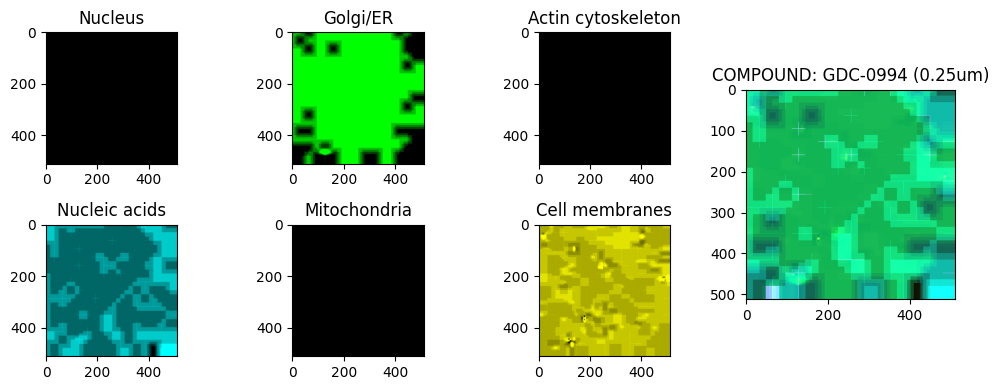

In [26]:
show_dataset_image(66154)

Most of these look like there are major artifacts in the cell painting or image acquisition. We will remove them from further analysis.

In [27]:
print('Shape before filtering: ', rxrx3.shape)
rxrx3 = rxrx3[rxrx3['PC2'] > -2]
print('Shape after filtering: ', rxrx3.shape)

Shape before filtering:  (200539, 398)
Shape after filtering:  (199897, 398)


In [28]:
#@title Centerscale on controls
#@markdown Following [Kraus et al.](https://arxiv.org/abs/2503.20158) we will normalize the embedding vectors of perturbation units by the controls for each batch, labeled in the columns `experiment_name`.
#@markdown The following two functions are taken from the [associated codebase](https://github.com/recursionpharma/EFAAR_benchmarking):
#@markdown * `centerscale_on_controls` : perform z-score normalization on controls, grouped by batch
#@markdown * `pca_centerscale_on_controls` : perform z-score normalization on controls, grouped by batch. Then, fit PCA *on controls only* and apply this transformation to all datapoints, per-batch. Krause et al. find this transformation improves gene-gene interaction recall

from sklearn.preprocessing import StandardScaler

def centerscale_on_controls(
    embeddings: np.ndarray,
    metadata: pd.DataFrame,
    pert_col: str,
    control_key: str,
    batch_col: str | None = None,
) -> np.ndarray:
    """
    Center and scale the embeddings on the control perturbation units in the metadata.
    If batch information is provided, the embeddings are centered and scaled by batch.

    Args:
        embeddings (numpy.ndarray): The embeddings to be aligned.
        metadata (pandas.DataFrame): The metadata containing information about the embeddings.
        pert_col (str, optional): The column in the metadata containing perturbation information.
        control_key (str, optional): The key for non-targeting controls in the metadata.
        batch_col (str, optional): Column name in the metadata representing the batch labels.
            Defaults to None.
    Returns:
        numpy.ndarray: The aligned embeddings.
    """
    embeddings = embeddings.copy()
    if batch_col is not None:
        batches = metadata[batch_col].unique()
        for batch in batches:
            batch_ind = metadata[batch_col] == batch
            batch_control_ind = batch_ind & (metadata[pert_col] == control_key)
            embeddings[batch_ind] = StandardScaler().fit(embeddings[batch_control_ind]).transform(embeddings[batch_ind])
        return embeddings

    else:
        control_ind = metadata[pert_col] == control_key
        return StandardScaler().fit(embeddings[control_ind]).transform(embeddings)


def pca_centerscale_on_controls(
    embeddings: np.ndarray,
    metadata: pd.DataFrame,
    pert_col: str,
    control_key: str,
    batch_col: str | None = None,
    n_components=None
) -> np.ndarray:
    """
    Fit PCA on controls then center and scale the embeddings on the control perturbation units.
    Args:
        embeddings (numpy.ndarray): The embeddings to be aligned.
        metadata (pandas.DataFrame): The metadata containing information about the embeddings.
        pert_col (str, optional): The column in the metadata containing perturbation information.
        control_key (str, optional): The key for non-targeting controls in the metadata.
        batch_col (str, optional): Column name in the metadata representing the batch labels. Defaults to None.
    Returns: numpy.ndarray: The aligned embeddings
    """
    X = embeddings.copy()
    X_controls = X[metadata[pert_col] == control_key]
    if not len(X_controls):
        raise ValueError(f"No control samples found for {control_key}")
    pca = PCA(n_components).fit(X_controls)
    X_pca = pca.transform(X)
    return centerscale_on_controls(X_pca, metadata, pert_col, control_key, batch_col=batch_col)


We'll append these transformed embeddings to our `rxrx3` object

In [29]:
pca_cs_embeddings = pca_centerscale_on_controls(
    rxrx3[embedding_cols], rxrx3, n_components = 10,
    pert_col = 'perturbation', batch_col = 'experiment_name', control_key='EMPTY_control')

pca_cs_embeddings = pd.DataFrame(pca_cs_embeddings, index = rxrx3.index).rename(columns = lambda x: "pca_centerscale_" + str(x))
pca_cs_embedding_cols = pca_cs_embeddings.columns.tolist()

print('Shape before adding columns: ', rxrx3.shape)
rxrx3 = pd.concat([rxrx3, pca_cs_embeddings], axis=1)
print('Shape after adding columns: ', rxrx3.shape)

Shape before adding columns:  (199897, 398)
Shape after adding columns:  (199897, 408)


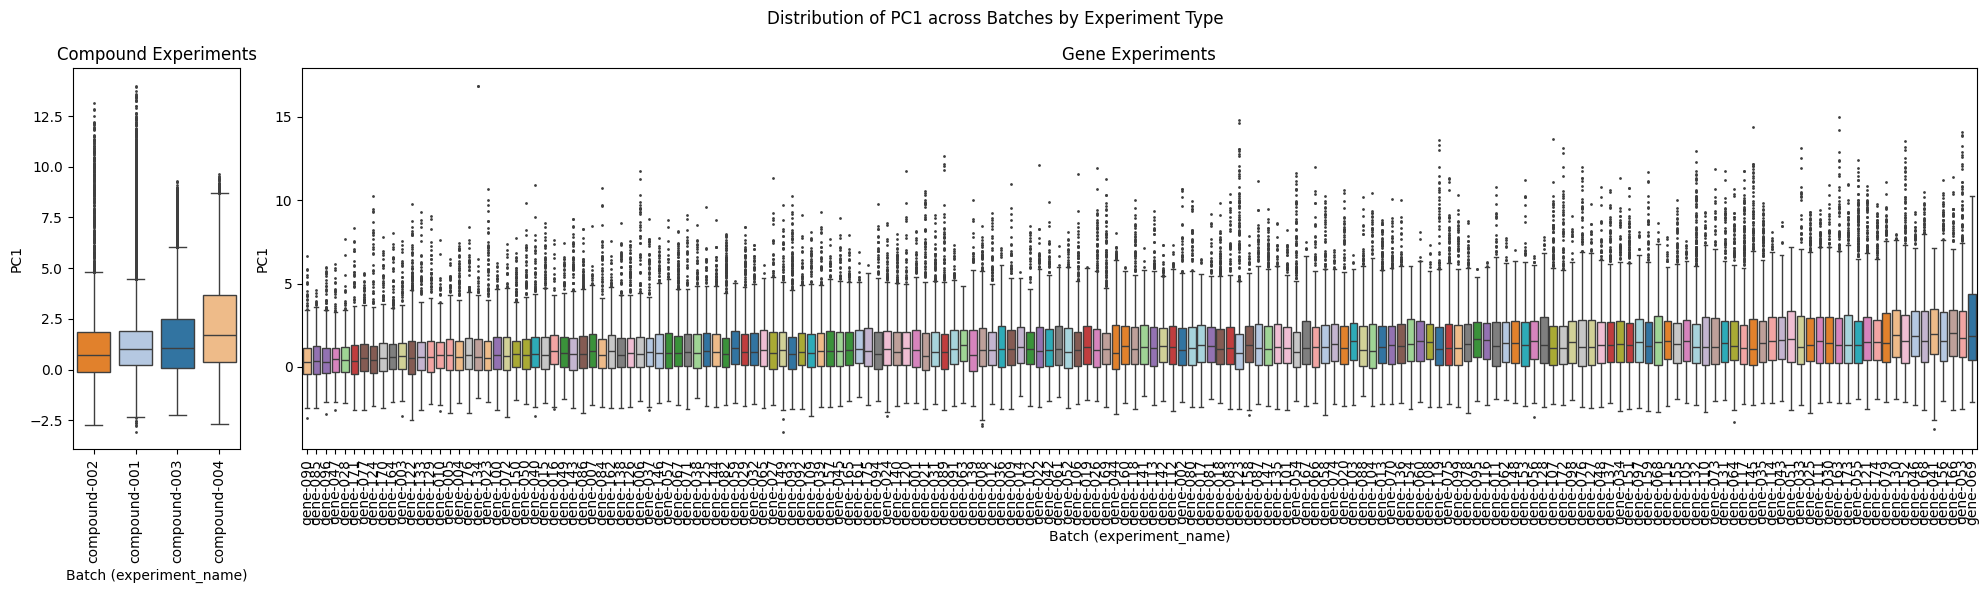

In [30]:
# @markdown This approach helps align batches, which now have more overlapping distributions in the PCA space

# Create subplots with different widths for gene vs compound experiments
fig, axes = plt.subplots(1,2, figsize=(20, 6), gridspec_kw={'width_ratios': [1, 10]})

for i, (exp_type, ax) in enumerate(zip(['compound', 'gene'], axes)):
    # Filter data for this experiment type
    data = rxrx3[rxrx3['experiment_type'] == exp_type]

    # Calculate mean PC1 for each experiment_name and sort
    means = data.groupby('experiment_name')['pca_centerscale_0'].mean().sort_values()
    order = means.index.tolist()

    # Create boxplot
    sns.boxplot(
        data=data,
        x='experiment_name',
        y='pca_centerscale_0',
        order=order,
        hue = 'experiment_name',
        palette='tab20',
        fliersize=1,
        legend=False,
        ax=ax
    )

    # Customize axes
    ax.set_xlabel('Batch (experiment_name)')
    ax.set_ylabel('PC1')
    ax.set_title(f'{exp_type.title()} Experiments')
    ax.tick_params(axis='x', rotation=90)

plt.suptitle('Distribution of PC1 across Batches by Experiment Type')
plt.tight_layout()
plt.show()

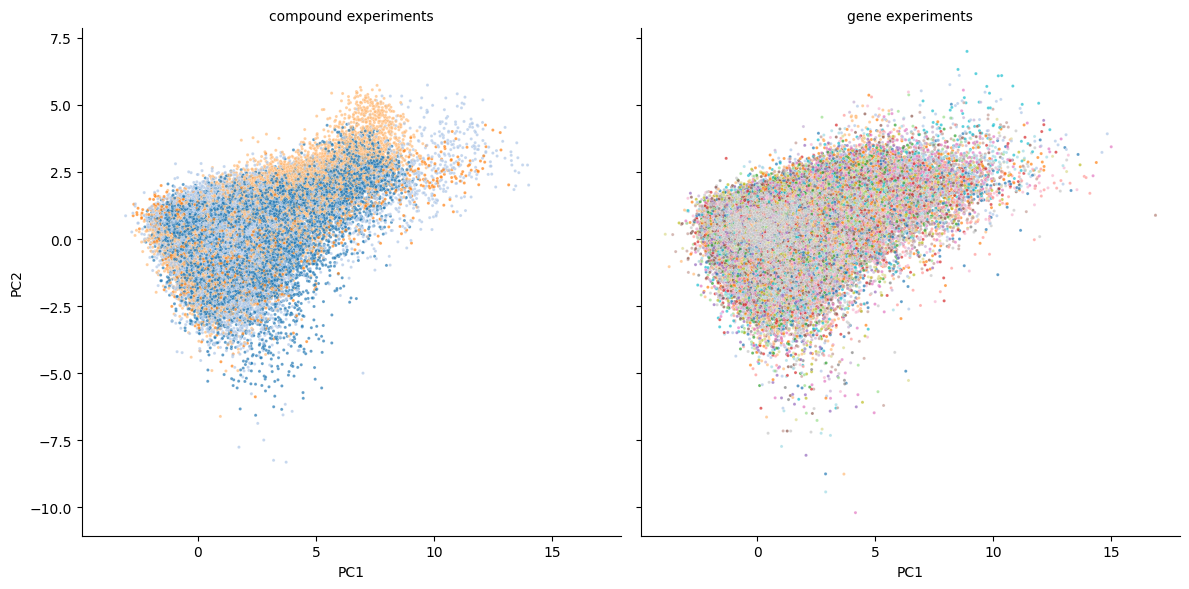

In [31]:
# @markdown And again in 2D

g = sns.FacetGrid(
    rxrx3,
    col="experiment_type",
    sharex=True,
    sharey=True,
    height=6,
    aspect=1
)
g.map_dataframe(
    sns.scatterplot,
    x='pca_centerscale_0',
    y='pca_centerscale_1',
    hue="experiment_name",
    palette="tab20",
    s=5,
    alpha=0.7,
    legend=False
)
g.set_axis_labels("PC1", "PC2")
g.set_titles(col_template="{col_name} experiments")


plt.tight_layout()
plt.show()

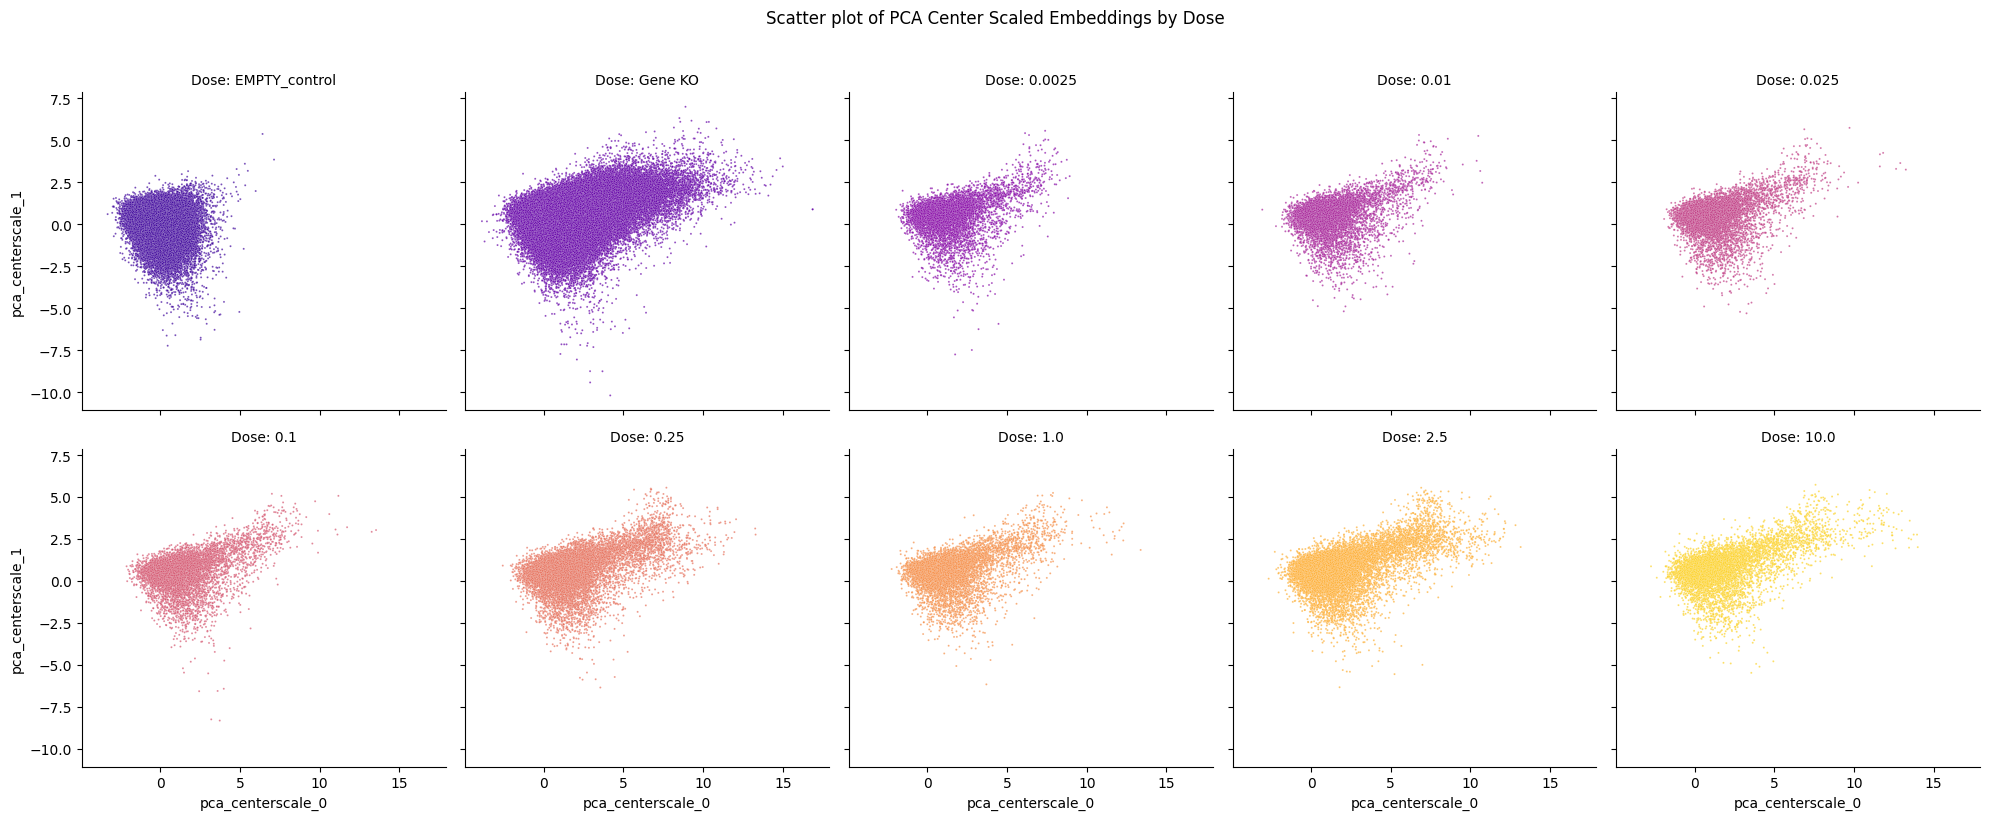

In [32]:
# @markdown We can also split these by dose, to understand what parts of PCA space the different samples occupy

g = sns.FacetGrid(
    rxrx3,
    col='Dose',
    col_wrap=5,
    height=4,
    aspect=1
)

g.map_dataframe(
    sns.scatterplot,
    x='pca_centerscale_0',
    y='pca_centerscale_1',
    hue='Dose',  # Color by dose
    palette='plasma',
    s=2,
    alpha=0.7,
    legend=False  # Turn off individual legends since we're faceting by dose
)

g.set_titles(col_template='Dose: {col_name}')

plt.suptitle('Scatter plot of PCA Center Scaled Embeddings by Dose', y=1.02)
plt.tight_layout()
plt.show()

## Average distance to control

In [33]:
# @markdown Now that we have mitigated major batch effects, we can compare the effects of different perturbations. We'll do so by taking the average distance of each sample to the control samples in the same batch. Like before, we will use the column `experiment_name` as the batch variable

def mean_dist_to_control(
    embeddings: np.ndarray,
    metadata: pd.DataFrame,
    pert_col: str,
    control_key: str,
    metric: str,
    batch_col: str | None = None,
) -> np.ndarray:
    """
    Calculate mean distance from each sample to control samples.

    Computes average distance between each sample and all controls, either
    globally or within batches to account for batch effects.

    Parameters
    ----------
    embeddings : np.ndarray
        Sample embeddings, shape (n_samples, n_features)
    metadata : pd.DataFrame
        Sample metadata with perturbation and batch info
    pert_col : str
        Column identifying perturbation type
    control_key : str
        Value identifying control samples (e.g., 'EMPTY_control')
    metric : str
        Distance metric ('euclidean', 'cosine', etc.)
    batch_col : str | None
        Column identifying batches. If None, calculate globally.

    Returns
    -------
    np.ndarray
        Mean distances to controls for each sample. NaN for samples
        in batches without controls.
    """
    distances = np.full(len(embeddings), np.nan)

    if batch_col is not None:
        # Process each batch separately to account for batch effects
        for batch in metadata[batch_col].unique():
            batch_ind = metadata[batch_col] == batch
            batch_control_ind = batch_ind & (metadata[pert_col] == control_key)
            if batch_control_ind.any():
                # For each row in this batch, compute mean pairwise distance to controls in batch
                batch_distances = pairwise_distances(
                    embeddings[batch_ind],
                    embeddings[batch_control_ind],
                    metric = metric
                ).mean(axis=1)
                distances[batch_ind] = batch_distances
    else:
        # if no batch variable, compare all samples to all control
        control_ind = metadata[pert_col] == control_key
        if control_ind.any():
            # For each row, compute mean pairwise distance to controls
            distances = pairwise_distances(
                embeddings,
                embeddings[control_ind],
                metric = metric
            ).mean(axis=1)

    return distances


### Choose a metric:
See [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html) for information on metric options
> 1. What distance metric should we use to compare the openphenom embeddings? batch-corrected PCA embeddings? Justify each choice
> 2. Fill in the code in the next cell

In [34]:
%%time
rxrx3['openphenom_distance_to_control'] = mean_dist_to_control(
    rxrx3[embedding_cols], rxrx3, pert_col='perturbation', control_key='EMPTY_control', batch_col='experiment_name',
    metric = '<pick a metric>'
)

rxrx3['pca_cs_distance_to_control'] = mean_dist_to_control(
    rxrx3[pca_cs_embedding_cols], rxrx3, pert_col='perturbation', control_key='EMPTY_control', batch_col='experiment_name',
    metric = '<pick a metric>'
)

CPU times: user 54.3 s, sys: 901 ms, total: 55.2 s
Wall time: 44.8 s


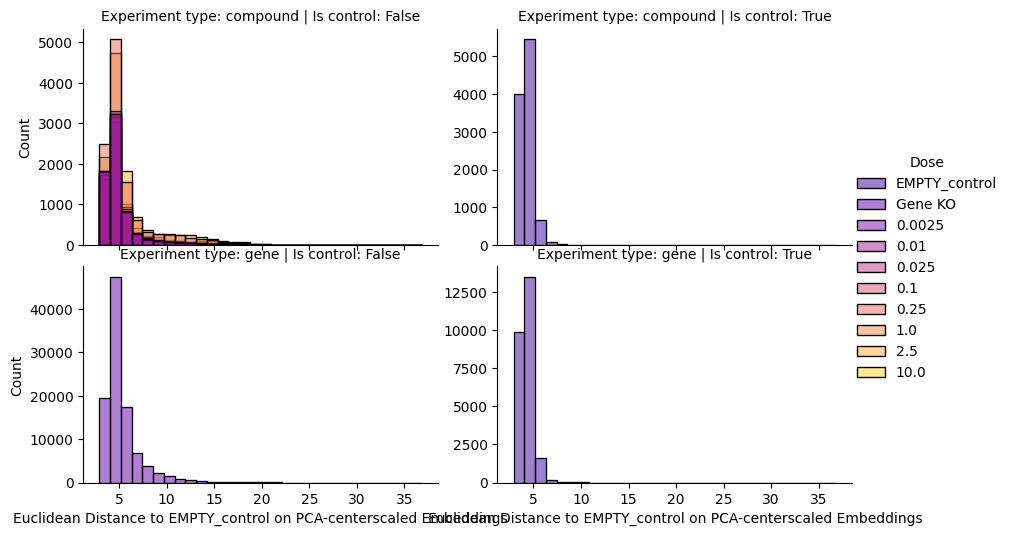

In [35]:
# @markdown Many experiments have an effect not much larger than the natural variance of the control units.

g = sns.displot(
    data=rxrx3,
    x='pca_cs_distance_to_control',
    hue='Dose',
    row='experiment_type',
    col = 'is_empty_control',
    kind='hist',
    bins=30,
    palette = 'plasma',
    facet_kws={'sharey': False, 'sharex': True}
)
g.fig.set_size_inches(10, 5)
g.set_axis_labels('Euclidean Distance to EMPTY_control on PCA-centerscaled Embeddings', 'Count')
g.set_titles(
    row_template='Experiment type: {row_name}',
    col_template = 'Is control: {col_name}'
)

plt.show()

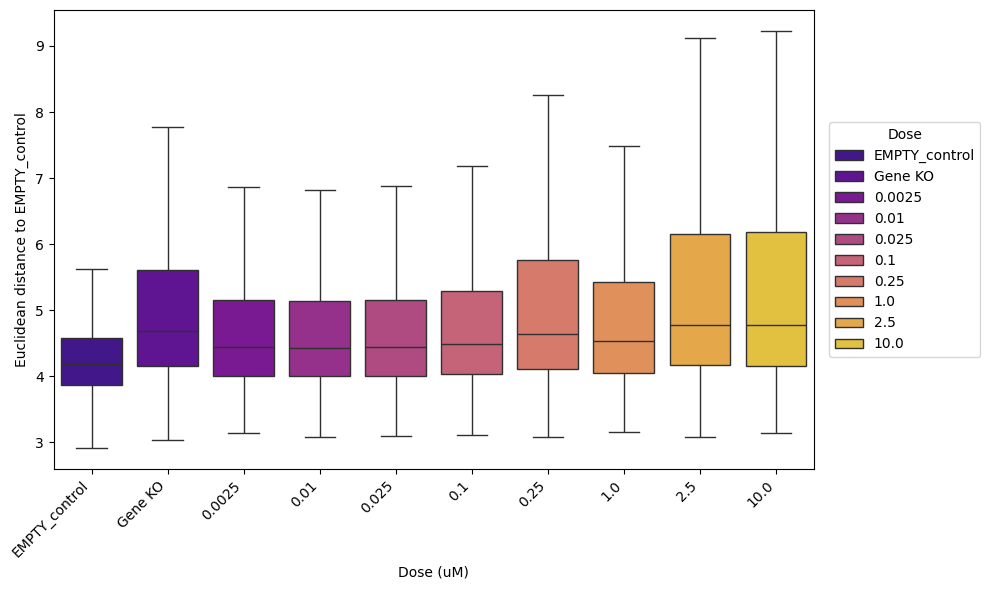

In [36]:
# @markdown For compound perturbations, higher dose has a slightly larger distance from the control than the lower dose. Gene perturbations embeddings fall somewhere in the middle for their distance to controls

plt.figure(figsize=(10, 6))

ax = sns.boxplot(
    data=rxrx3,
    x='Dose',
    y='pca_cs_distance_to_control',
    hue='Dose',
    showfliers=False,
    palette='plasma'
)

plt.xlabel('Dose (uM)')
plt.ylabel('Euclidean distance to EMPTY_control')
plt.xticks(rotation=45, ha='right')

# Move legend to the right
plt.legend(title='Dose', bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0.)

plt.tight_layout()
plt.show()

## Simpsons paradox

Simpson's Paradox is a statistical phenomenon where a trend that appears in different groups of data disappears or reverses when the groups are combined. It's a counterintuitive result that highlights the importance of careful data analysis and the potential dangers of drawing conclusions without considering all relevant variables.

Confounding Variables: The paradox typically occurs due to the presence of a confounding variable that influences both the independent and dependent variables

### Make a guess:
> 1. Which perturbation type do you think will have a larger median effect, a compound or a genetic knockout?



First, we'll calcualte the average distance to controls across perturbation types

In [60]:
rxrx3_grouped = rxrx3[rxrx3['is_empty_control']==False].groupby(
    ['experiment_type', 'experiment_name', 'perturbation'],
    observed=True, dropna=False
)[['pca_cs_distance_to_control']].mean().reset_index()


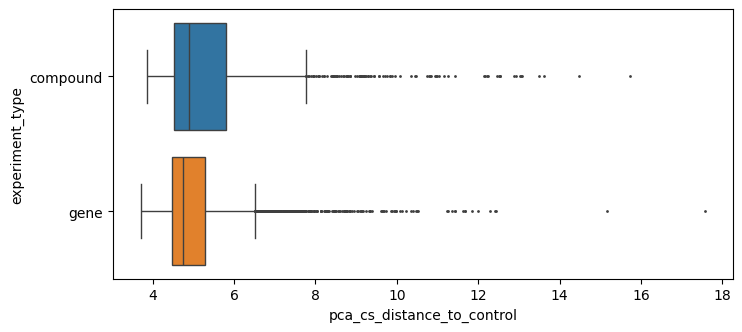

Median effect size for compound: 4.898
Median effect size for gene: 4.740


In [61]:
# @markdown Let's test it by looking at the average distance to control unit of each perturbation
plt.figure(figsize=(8,3.5))
ax = sns.boxplot(
    data=rxrx3_grouped,
    x='pca_cs_distance_to_control',
    y='experiment_type',
    hue = 'experiment_type',
    legend=False,
    fliersize=1,
    showfliers=True
)
plt.show()

compound_data = rxrx3_grouped[rxrx3_grouped['experiment_type'] == 'compound']['pca_cs_distance_to_control']
gene_data = rxrx3_grouped[rxrx3_grouped['experiment_type'] == 'gene']['pca_cs_distance_to_control']

print(f"Median effect size for compound: {np.median(compound_data):.3f}")
print(f"Median effect size for gene: {np.median(gene_data):.3f}")

Based off this plot, it appears that the compound treatments have a larger median effect on our embedding distance to control units than the genetic knockouts.

However, there may be other variables we should account for. Let's now additionally group by Dose. This will give us the average across replicates

In [62]:
rxrx3_grouped = rxrx3[rxrx3['is_empty_control']==False].groupby(
    ['experiment_type', 'experiment_name', 'perturbation', 'Dose'],
    observed=True, dropna=False
)[['pca_cs_distance_to_control']].mean().reset_index()


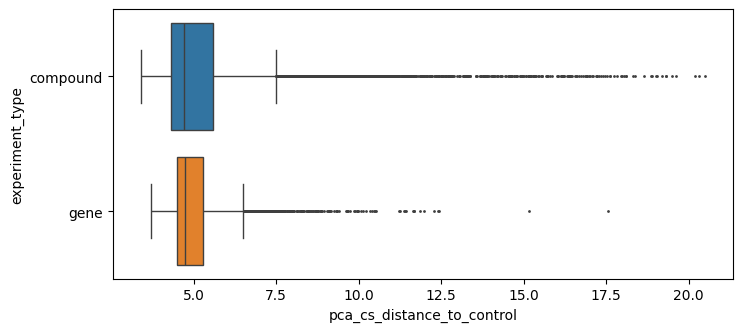

Median effect size for compound: 4.714
Median effect size for gene: 4.740


In [63]:
# @markdown The difference in medians reverses: genetic knockouts have a larger effect!

plt.figure(figsize=(8,3.5))
ax = sns.boxplot(
    data=rxrx3_grouped,
    x='pca_cs_distance_to_control',
    y='experiment_type',
    hue = 'experiment_type',
    legend=False,
    fliersize=1,
    showfliers=True
)
plt.show()

compound_data = rxrx3_grouped[rxrx3_grouped['experiment_type'] == 'compound']['pca_cs_distance_to_control']
gene_data = rxrx3_grouped[rxrx3_grouped['experiment_type'] == 'gene']['pca_cs_distance_to_control']

print(f"Median effect size for compound: {np.median(compound_data):.3f}")
print(f"Median effect size for gene: {np.median(gene_data):.3f}")

### With your team:
> 1. Suggest an explaination for why accounting for dose reduces the median distance to control for compounds
> 1. Now, edit the grouping code to also account for well location using `well_row` and `well_col`. Is there evidence that we should normalize to these in addition to batch?
> 1. Why is it standard to randomize the assignment of samples by well and plate?
> 1. Give an example of a batch effect that randomized the assignment may not solve

In [46]:
rxrx3_grouped = rxrx3[rxrx3['is_empty_control']==False].groupby(
    ['experiment_type', 'experiment_name', 'perturbation', 'Dose'], # change this grouping
    observed=True, dropna=False
)[['pca_cs_distance_to_control']].mean().reset_index()

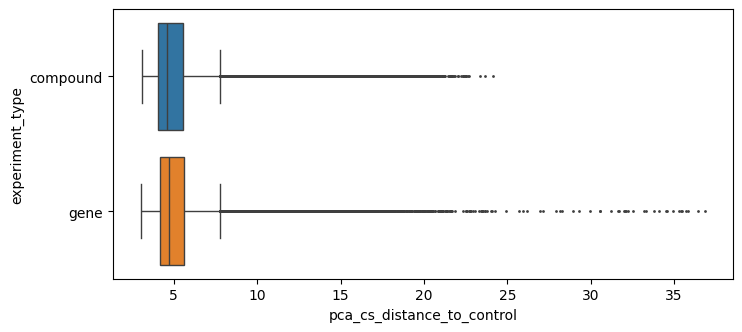

Median effect size for compound: 4.569
Median effect size for gene: 4.684


In [47]:
# @markdown The results in this plot should change when you change the grouping variables

plt.figure(figsize=(8,3.5))
ax = sns.boxplot(
    data=rxrx3_grouped,
    x='pca_cs_distance_to_control',
    y='experiment_type',
    hue = 'experiment_type',
    legend=False,
    fliersize=1,
    showfliers=True
)
plt.show()

compound_data = rxrx3_grouped[rxrx3_grouped['experiment_type'] == 'compound']['pca_cs_distance_to_control']
gene_data = rxrx3_grouped[rxrx3_grouped['experiment_type'] == 'gene']['pca_cs_distance_to_control']

print(f"Median effect size for compound: {np.median(compound_data):.3f}")
print(f"Median effect size for gene: {np.median(gene_data):.3f}")

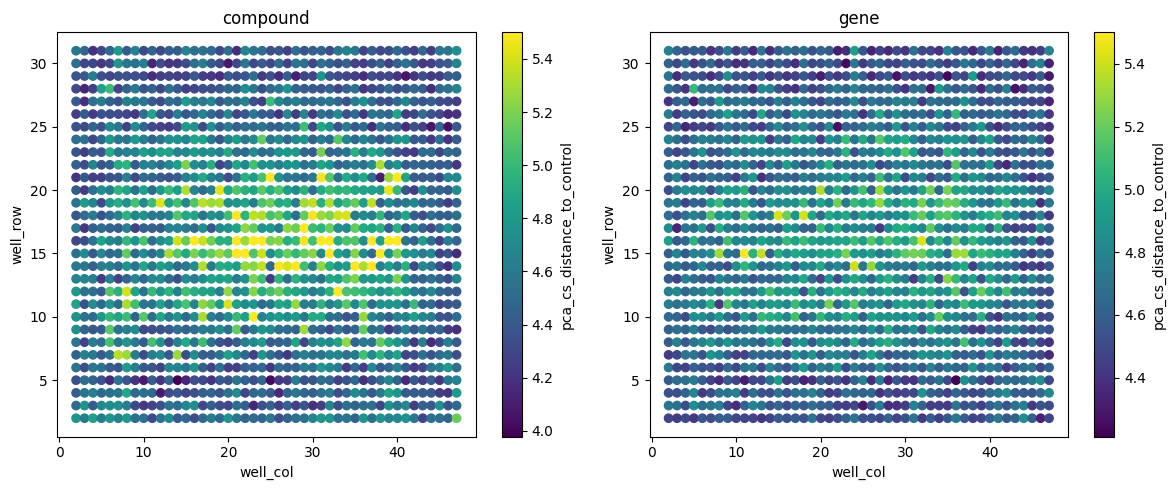

In [49]:
# @markdown Now we can look at the effect per- well location!

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for i, (exp_type, group) in enumerate(rxrx3_grouped.groupby('experiment_type')):
    scatter_df = group.groupby(['well_row', 'well_col'], observed=True, dropna=False)['pca_cs_distance_to_control'].median().reset_index()
    sc = axs[i].scatter(
        scatter_df['well_col'],
        scatter_df['well_row'],
        c=scatter_df['pca_cs_distance_to_control'],
        cmap='viridis',
        vmax = 5.5
    )
    axs[i].set_title(f"{exp_type}")
    axs[i].set_xlabel('well_col')
    axs[i].set_ylabel('well_row')
    plt.colorbar(sc, ax=axs[i], label='pca_cs_distance_to_control')

plt.tight_layout()
plt.show()

## Your team compound

We'll consider the compounds which have the greatest effect on embeddings to investigate further.



Lets summarize over replicates by averaging embeddings. This cleans up some outliers and improves visualization

In [50]:
summary = rxrx3.groupby(
    ['experiment_type', 'is_empty_control', 'perturbation', 'concentration', 'Dose'],
    observed=True, dropna=False
)[pca_cs_embedding_cols + ['pca_cs_distance_to_control']].mean().reset_index()

Let's take a look at the top 30 compounds with the largest average distance from their controls




In [51]:
top_30 = summary[summary['experiment_type']=='compound'].sort_values(by = 'pca_cs_distance_to_control', ascending = False)['perturbation'].unique()[0:31]
top_30

array(['Ivacaftor', 'RG-7112', 'ABT-263', 'Foretinib', 'proscillaridin-a',
       'Entrectinib', 'Visomitin', 'Dronedarone', 'digitoxin',
       'Bazedoxifene', 'Endoxifen', 'anlotinib', 'GSK2126458',
       'Toremifene', 'BI 2536', 'GSK1059615', 'Ioversol', 'R 7050',
       'AZD4547', 'Tamoxifen', 'LDK378', 'Tivozanib', 'Triflupromazine',
       'Bortezomib', 'Temsirolimus', 'Mitoxantrone',
       'Gemcitabine hydrochloride', 'digoxin', 'Halofuginone',
       'Thimerosal', 'Carfilzomib'], dtype=object)

In [52]:
summary_top_30 = summary[summary['perturbation'].isin(top_30)]
summary_top_30

experiment_type  is_empty_control      perturbation concentration  \
232          compound             False           ABT-263        0.0025   
233          compound             False           ABT-263          0.01   
234          compound             False           ABT-263         0.025   
235          compound             False           ABT-263           0.1   
236          compound             False           ABT-263          0.25   
...               ...               ...               ...           ...   
12382        compound             False  proscillaridin-a           0.1   
12383        compound             False  proscillaridin-a          0.25   
12384        compound             False  proscillaridin-a           1.0   
12385        compound             False  proscillaridin-a           2.5   
12386        compound             False  proscillaridin-a          10.0   

         Dose  pca_centerscale_0  pca_centerscale_1  pca_centerscale_2  \
232    0.0025           2.773738           0.207702          -1.109682   
233      0.01           2.723242           0.091919          -2.406172   
234     0.025           2.845859           0.284940          -1.558053   
235       0.1           4.676344           2.288576          -4.552188   
236      0.25           3.726996           0.689230          -2.633963   
...       ...                ...                ...                ...   
12382     0.1          11.183698           3.603294          -4.307343   
12383    0.25          10.937743           3.904680          -4.833803   
12384     1.0          11.455908           3.342255          -5.074520   
12385     2.5           8.869545           3.438944          -4.546225   
12386    10.0          11.174232           4.543355          -6.095466   

       pca_centerscale_3  pca_centerscale_4  pca_centerscale_5  \
232            -0.105755           0.055966           0.454685   
233            -0.605959           0.194074           0.843293   
234             0.530544           0.175441           0.480198   
235            -0.893783          -1.072636           3.308444   
236            -0.335367          -0.142611           1.209444   
...                  ...                ...                ...   
12382           0.709994          -1.924204           5.216458   
12383           1.952469          -3.346910           4.783039   
12384          -0.198357          -1.744590           6.457244   
12385           1.017841          -2.130902           4.939857   
12386           1.614421          -3.418054           6.144473   

       pca_centerscale_6  pca_centerscale_7  pca_centerscale_8  \
232            -1.019455           0.429744           0.274188   
233            -1.058727          -0.443491           2.123048   
234            -1.296073           0.727572           1.560160   
235            -5.111648          -0.432684           3.248641   
236            -2.217956          -0.738806           2.080707   
...                  ...                ...                ...   
12382          -5.990189          -0.260429           6.725074   
12383          -6.290852          -0.073315           5.768711   
12384          -6.846884          -0.425376           6.918300   
12385          -5.239476          -0.249563           4.177831   
12386          -7.494995          -0.005687           6.172553   

       pca_centerscale_9  pca_cs_distance_to_control  
232             0.544903                    4.923717  
233            -0.083659                    6.027238  
234             0.120886                    5.684169  
235             0.889511                   11.088605  
236             0.375487                    6.836032  
...                  ...                         ...  
12382          -0.072412                   16.935912  
12383           0.153677                   16.801560  
12384          -0.306145                   18.100345  
12385           0.569742                   14.947392  
12386           0.944649 

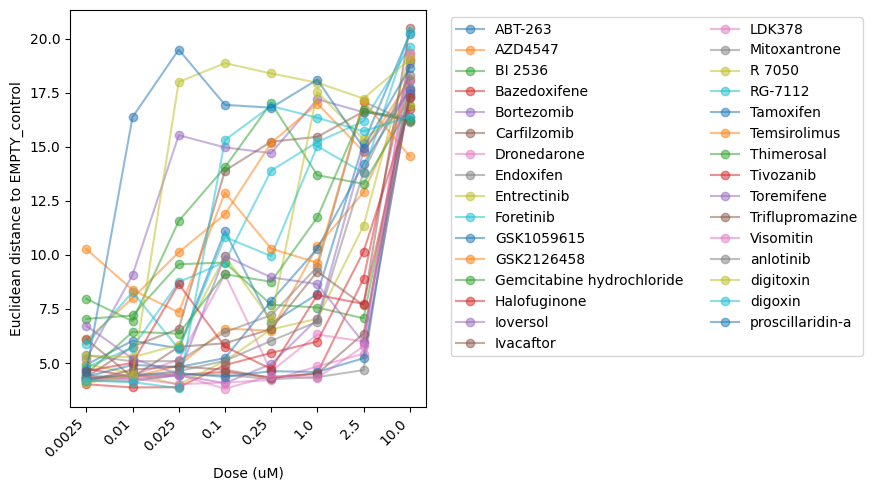

In [53]:
# @markdown Top 30 most potent compounds behave differently at different doses

plt.figure(figsize=(9, 5))

for pert, group in summary_top_30.groupby('perturbation'):
    plt.plot(
        group["concentration"].cat.codes,
        group["pca_cs_distance_to_control"],
        marker='o', linestyle='-',
        alpha=0.5,
        label=pert  # Add label for each group
    )


dose_categories = summary_top_30['concentration'].cat.categories
plt.xticks(range(len(dose_categories)), dose_categories, rotation=45, ha='right')
plt.xlabel("Dose (uM)")
plt.ylabel("Euclidean distance to EMPTY_control")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.tight_layout()
plt.show()


Your compound is: AZD4547


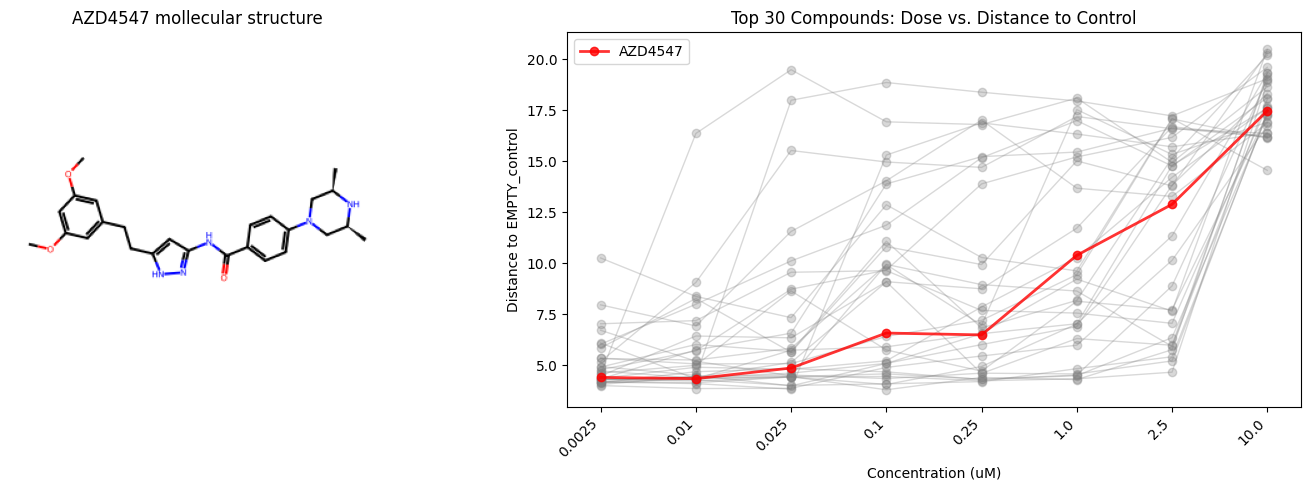

In [54]:
#@title Investigate a compound
#@markdown Each team is assigned a compound! Enter your team number to get yours
# Each team is assigned a compound! Enter your team number to get yours
team_number = 1 #@param {type:"number"}

team_compound = summary_top_30['perturbation'].unique()[team_number]
idx = metadata[metadata['perturbation']==team_compound].index[0]
m_smile = dataset.get_data(row=idx, col='SMILES')

print(f'Your compound is:', dataset.get_data(row=idx, col='treatment'))

m_mol = Chem.MolFromSmiles(m_smile)

# Create side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Left subplot: Molecular structure
mol_img = Chem.Draw.MolToImage(m_mol)
ax1.imshow(mol_img)
ax1.axis('off')
ax1.set_title(f'{team_compound} mollecular structure')

# Right subplot: Dose-response plot
for pert, group in summary_top_30.groupby('perturbation'):
    is_highlight = pert == team_compound
    ax2.plot(
        group["concentration"].cat.codes,
        group["pca_cs_distance_to_control"],
        marker='o', linestyle='-',
        alpha=0.8 if is_highlight else 0.3,
        color='red' if is_highlight else 'grey',
        zorder=2 if is_highlight else 1,
        linewidth=2 if is_highlight else 1,
        label=pert if is_highlight else None
    )

ax2.legend()
dose_categories = summary_top_30['concentration'].cat.categories
ax2.set_xticks(range(len(dose_categories)))
ax2.set_xticklabels(dose_categories, rotation=45, ha='right')
ax2.set_xlabel("Concentration (uM)")
ax2.set_ylabel("Distance to EMPTY_control")
ax2.set_title("Top 30 Compounds: Dose vs. Distance to Control")

plt.tight_layout()
plt.savefig('./foo.png', dpi=300, bbox_inches='tight')
plt.show()

### With your assigned compound, answer the following:
>1. Is it appropriate to interpret the above plot as a dose response curve?  Suggest a reason why or why not
>2. Does the distance to `EMPTY_control` increase monotonically with Concentration? Suggest a reason why or why not
>2. Does this relationship have an inflection point? Suggest a reason why or why not
>3. What would expect this plot to look like if the compound were cytotoxic above concentration 0.25uM, causing cells to die?


/tmp/ipython-input-2879781109.py:36: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


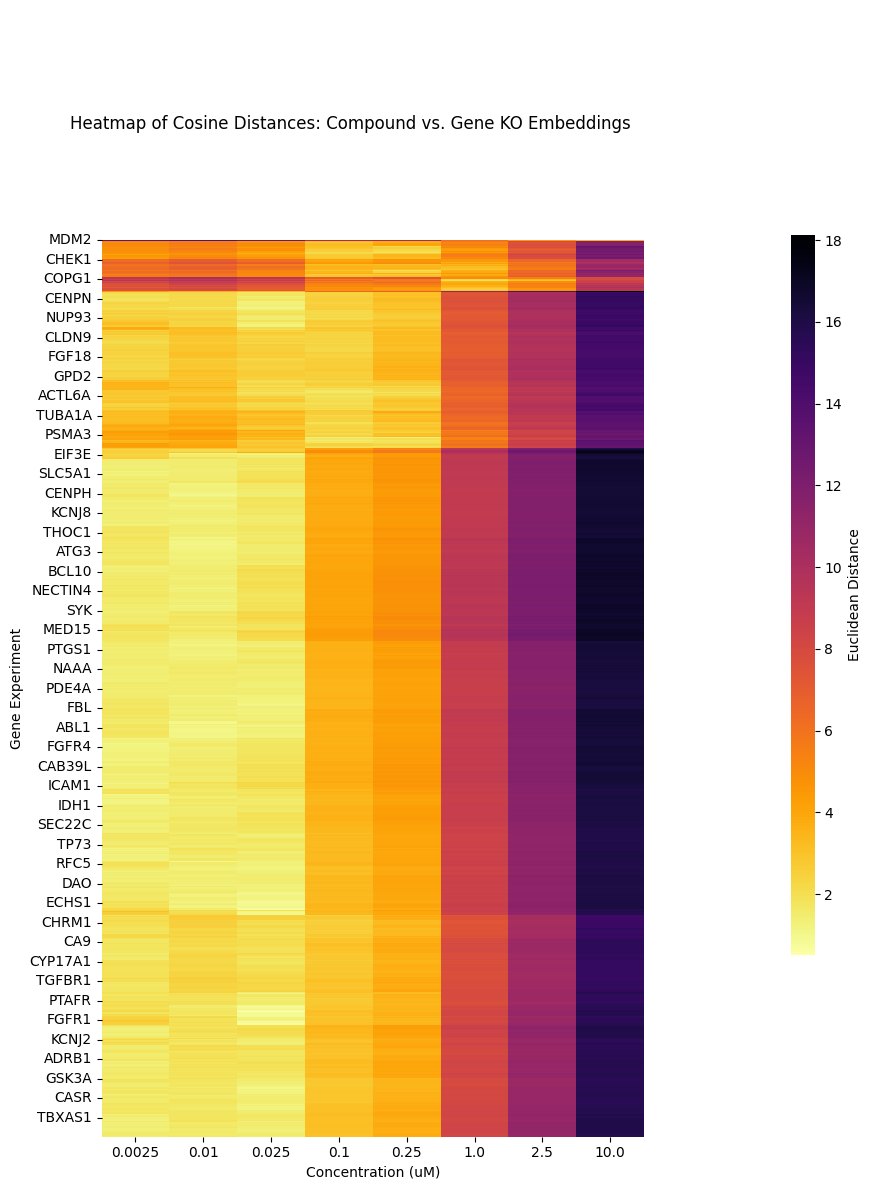

In [55]:
# @markdown Now look into genetic knockouts with similar embeddings. Are any of these the targets of your compound?

compound_experiments = summary[summary['perturbation'] == team_compound]
gene_experiments = summary[summary['experiment_type'] == 'gene']

# Compute cosine distances between your compound and all genes
dist_df = pd.DataFrame(
    pairwise_distances(
        gene_experiments[pca_cs_embedding_cols],
        compound_experiments[pca_cs_embedding_cols],
        metric = 'euclidean'
    ), # shape (n_genes, n_concentrations)
    index= gene_experiments['perturbation'],
    columns = compound_experiments['concentration']
)

# Cluster and plot heatmap with legend on the right and y-axis on the left
g = sns.clustermap(
    dist_df,
    method='average',
    cmap='inferno_r',
    col_cluster=False,
    row_cluster=True,
    figsize=(8, 12),
    cbar_pos=(1.05, 0.2, 0.03, 0.6)
)
# Set colorbar title
g.cax.set_ylabel("Euclidean Distance")
g.ax_heatmap.set_xlabel('Concentration (uM)')
g.ax_heatmap.set_ylabel('Gene Experiment')
g.ax_heatmap.yaxis.set_label_position("left")
g.ax_heatmap.yaxis.tick_left()
g.ax_row_dendrogram.set_visible(False)  # y-axis/row dendrogram (default left)
g.ax_heatmap.yaxis.set_ticks_position('left')
g.fig.suptitle('Heatmap of Cosine Distances: Compound vs. Gene KO Embeddings', y = 0.9)
plt.tight_layout()
plt.show()


Get the top most similar genes

In [56]:
# sort by closest
dist_df.max(axis=1).sort_values()

perturbation
POLR2B       8.710927
SNRPD3       9.105771
COPG1        9.138379
EIF3G        9.222071
RPL7A        9.263047
              ...    
SERPINA6    17.003855
DMAC2L      17.029919
ROCK2       17.146696
TP53        17.337580
EIF3D       18.123573
Length: 736, dtype: float32

In [58]:
# For each concentration, find the genes (row) with the minimum distance (most similar)
top_n = 5
top_genes_per_conc = dist_df.apply(lambda col: col.nsmallest(top_n).index.tolist(), axis=0)
top_genes_per_conc


concentration   0.0025     0.01  0.025    0.1    0.25    1.0     2.5    10.0
0                 COMT  SLC27A1  COX17    AQR     AQR   RPS8    RPS8    MDM2
1                NUP37    CASP6   COPE  SNRPF   SNRPF  COPG1   COPG1   RPS11
2                  NBN      PLG   LSM2  RPS19  SNRPD2  RPL7A    MDM2   COPG1
3              HSD11B2   RAD51B   RFC4   RPS9   RPS19   RPS6   RPL7A    RPS8
4                HACD1  EXOSC10   RFC3  RPL30  POLR2L  RPS4X  POLR2B  SNRPD3

In [59]:
control_mask = dist_df.max(axis=1).sort_values().index.str.contains('EMPTY_control')
control_rank = np.where(control_mask)[0][0]
print('First EMPTY_control:', control_rank)
print('Percentage of genes above this:', round((control_rank / len(dist_df))*100), '%' )

First EMPTY_control: 728
Percentage of genes above this: 99 %


### Answer the following:
> 1. Biological signaificance: Look up your compound and the top three genes as potential targets. Evaluate the strength of the evidence for these gene-compound similarities.
> 2. What rank is the closest EMPTY_control? What proportion of genes are above this?
> 3. Statistical significance: Are the top ranked genes more similar than you would expect at random? Describe and implement a null distribution to test this

In [ ]:
# implement a null distribution here



# Post-module: compare with cell-features

In [ ]:
import sys
sys.path.append('./ScaleFEx')
from ScaleFEx_from_crop.compute_ScaleFEx import ScaleFEx
from Nuclei_segmentation import nuclei_location_extraction as nls

## Single-cell feature extraction

Classical methods rely on cell segmentation and quantification of morphological features such as length, width, shape, texture, etc.

[CellProfiler](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-021-04344-9) is a popular GUI-based tool for this

As a python option, we'll use [ScaleFEx](https://doi.org/10.1016/j.isci.2024.111434), which is designed to extract cell profiler features from a cell painting experiment.


## Nuclei segmentation

It's relatively easy to segment nuclei because they tend to be far apart, whereas cytoplasmic segmentation of cell boundaries can be more challenging, especially for cells with elongated morphology, or those packed closely together.

In this example, we'll use a simple segmentation method to identify nuclei: otsu thresholding to separate the foreground from background and create a mask of which pixels are nuclei, followed by watershed to identify separate nuclei which may be touching in the mask. There are many other methods to perform this type of segmentation, including deep learning based approaches.

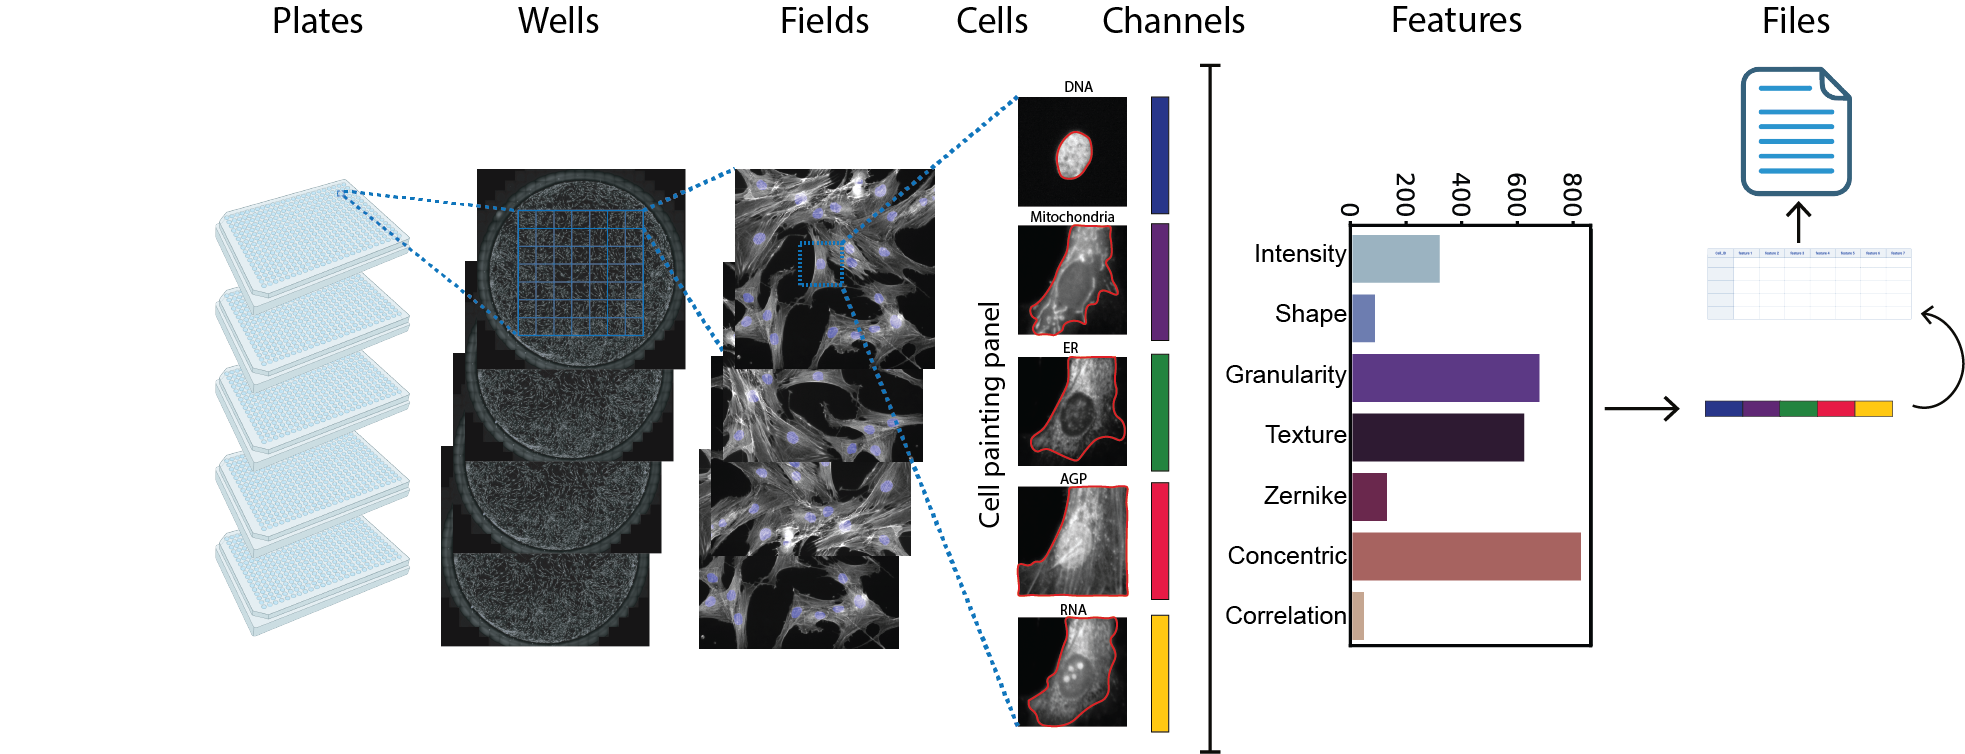

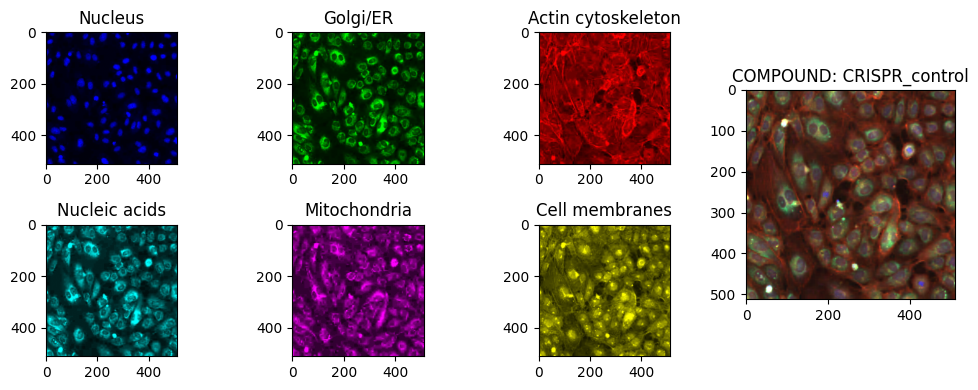

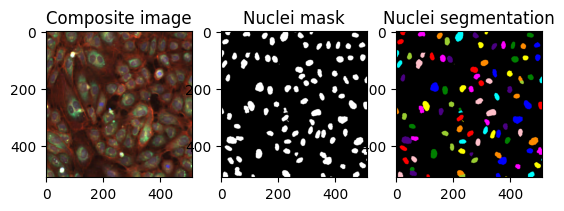

In [ ]:
# @markdown Pick an image to view and  segment (number between 0 and 222601)
image_number = 234 #@param {type:"number"}
show_dataset_image(image_number)

img_data = dataset.get_data(row=image_number, col='images').T
nuc_ch = img_data[0]

# detect forground mask with thresholding
thresholds = ski.filters.threshold_multiotsu(nuc_ch, classes=3)
regions = np.digitize(nuc_ch, bins=thresholds)
nuclei_mask = nuc_ch > thresholds[0]

# segment individual nuclei with watershed algorithm
distance = ndimage.distance_transform_edt(nuclei_mask)
local_max_coords = ski.feature.peak_local_max(
    distance, min_distance=7, exclude_border=False
)
local_max_mask = np.zeros(distance.shape, dtype=bool)
local_max_mask[tuple(local_max_coords.T)] = True
markers = ski.measure.label(local_max_mask)

segmented_nuclei = ski.segmentation.watershed(-distance, markers, mask=nuclei_mask)

fig, ax = plt.subplots(1,3)
ax[0].imshow(make_composite(img_data))
ax[0].set_title('Composite image')
ax[1].imshow(nuclei_mask, cmap = 'gray')
ax[1].set_title('Nuclei mask')
ax[2].imshow(ski.color.label2rgb(segmented_nuclei, bg_label=0))
ax[2].set_title('Nuclei segmentation')
plt.show()

In [ ]:
print(f'Segmented {segmented_nuclei.max()} nuclei')

Segmented 103 nuclei


Now get the center of mass for each nuclei. ScaleFEx will use this to create a crop around the cell based off a specified padding size

In [ ]:
center_of_mass = nls.retrieve_coordinates(
    segmented_nuclei,
    cell_size_min=-np.inf,  # adjust as needed
    cell_size_max=np.inf  # adjust as needed
)

roi = 32  # size of region of interest to crop to (approximate nucleus size)

In [ ]:
# @title Apply ScaleFEx to your compound
# @markdown ScaleFEx works by taking a crop around each cell, and measuring morphological attributes. Each measurement is a cell-specific feature. We provide some convenience functions for applying ScaleFEx to each image. Images with >100 cells can be slow, so the `max_cells_per_image` argument allows you to measure only a subset of cells in each image. Expand the code below to investigate the implementation of the following functions:
# @markdown * single_cell_scalefex - function to crop and measure one cell
# @markdown * apply_scalefex_to_image - function to crop and measure all cells in a single image

channel_names = ['Nucleus', 'Golgi/ER',  'Actin cytoskeleton', 'Nucleic acids', 'Mitochondria', 'Cell membranes']


def single_cell_scalefex(n, x, y, img_data, channel_names, roi):
    """Process a single cell and return features or None if failed"""
    try:
        x, y = int(x), int(y)

        # Check if crop would be out of bounds
        if (x - roi < 0 or x + roi >= img_data.shape[1] or
            y - roi < 0 or y + roi >= img_data.shape[2]):
            return None

        crop = img_data[:, x-roi:x+roi, y-roi:y+roi, np.newaxis]

        # Check crop shape
        if crop.shape != (len(channel_names), roi*2, roi*2, 1):
            return None

        # Suppress warnings and process
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            scalefex = ScaleFEx(
                crop,
                channel=channel_names,
                mito_ch=4,
                rna_ch=3,
                downsampling=1,
                visualization=False,
                roi=roi
            ).single_cell_vector

        # Check if we got valid results
        if isinstance(scalefex, pd.DataFrame):
            return scalefex

    except Exception as e:
        # Skip failed cells silently
        pass

    return None

def apply_scalefex_to_image(img_data, max_cells_per_image=25, roi=32, channel_names=channel_names):
    """
    Apply ScaleFEx to a single image.

    Parameters:
    -----------
    img_data : numpy array
        Image data with shape (channels, height, width)
    max_cells_per_image : int, default=25
        Maximum number of cells to process per image
    roi : int, default=32
        Size of region of interest to crop around each cell
    channel_names : list
        List of channel names for the images

    Returns:
    --------
    list
        List of DataFrames containing ScaleFEx features for each processed cell
    """
    nuc_ch = img_data[0]

    # Quick segmentation
    thresholds = ski.filters.threshold_multiotsu(nuc_ch, classes=3)
    nuclei_mask = nuc_ch > thresholds[0]
    nuclei_mask = ski.morphology.remove_small_objects(nuclei_mask, min_size=50)

    distance = ndimage.distance_transform_edt(nuclei_mask)
    coords = ski.feature.peak_local_max(distance, min_distance=10, threshold_abs=5)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndimage.label(mask)
    segmented_nuclei = ski.segmentation.watershed(-distance, markers, mask=nuclei_mask)

    # Get cell coordinates
    center_of_mass = nls.retrieve_coordinates(segmented_nuclei, cell_size_min=-np.inf, cell_size_max=np.inf)

    # Process cells for this image
    image_features = []
    successful_count = 0

    for n, (x, y) in enumerate(center_of_mass):
        if successful_count >= max_cells_per_image:
            break

        result = single_cell_scalefex(n, x, y, img_data, channel_names, roi)
        if result is not None:
            result['cell_id'] = n
            image_features.append(result)
            successful_count += 1

    return image_features


As a demo, here's how you can measure the cells in one image. Some images with many cells can be slow to process, so we put a 50 cell max on how many cells to measure per image.

In [ ]:
%%time
# Single image example
features = []
max_cells_per_image = 50

# Sample max_cells_per_image random rows
rng = np.random.default_rng()
cells_sample = rng.choice(center_of_mass, size=max_cells_per_image, axis=0)

print(f"Processing up to {max_cells_per_image} cells per image...")

for n, (x, y) in enumerate(cells_sample):
    result = single_cell_scalefex(n, x, y, img_data, channel_names, roi)
    if result is not None:
        features.append(result)

# Combine results
if features:
    sfex_features = pd.concat(features, ignore_index=True)
    print(f"Successfully processed {len(features)} cells")
    print(f"Feature shape: {sfex_features.shape}")
else:
    print("No features extracted")
    sfex_features = pd.DataFrame()

Processing up to 50 cells per image...
Successfully processed 38 cells
Feature shape: (38, 2229)
CPU times: user 1min 4s, sys: 141 ms, total: 1min 4s
Wall time: 1min 1s


We will make a small dataframe for just your team compound at the max concentration (10um) and some randomly sampled controls

In [ ]:
# get data for team compound
pert_mask = (rxrx3['perturbation'] == team_compound) & (rxrx3['concentration'] == '10.0')
perts = rxrx3[pert_mask]

# pick 10 random control images
batch_sel = rxrx3[pert_mask]['experiment_name'].unique()
control_mask = (rxrx3['experiment_name'].isin(batch_sel)) & (rxrx3['is_empty_control'])
controls = rxrx3[control_mask].sample(5)

# create team df
rxrx3_team = pd.concat([perts,controls])
rxrx3_team

dataset_index      treatment experiment_name concentration  plate  \
39855           46289        AZD4547    compound-001          10.0     25   
77070           89408        AZD4547    compound-001          10.0     34   
113074         131167        AZD4547    compound-001          10.0     28   
132120         153311        AZD4547    compound-001          10.0     31   
23742           27536  EMPTY_control    compound-001           NaN     42   
111495         129332  EMPTY_control    compound-001           NaN     15   
104556         121267  EMPTY_control    compound-001           NaN     41   
98913          114752  EMPTY_control    compound-001           NaN     12   
132213         153415  EMPTY_control    compound-001           NaN     34   

       address experiment_type   perturbation  is_empty_control  well_col  \
39855      N41        compound        AZD4547             False        41   
77070      Y31        compound        AZD4547             False        31   
113074     U06        compound        AZD4547             False         6   
132120    AD36        compound        AZD4547             False        36   
23742      H47        compound  EMPTY_control              True        47   
111495     W26        compound  EMPTY_control              True        26   
104556     K35        compound  EMPTY_control              True        35   
98913      V04        compound  EMPTY_control              True         4   
132213     U34        compound  EMPTY_control              True        34   

        ...  pca_centerscale_2 pca_centerscale_3  pca_centerscale_4  \
39855   ...          -5.647553         -2.969692           0.011644   
77070   ...          -4.512185         -0.724967          -0.881188   
113074  ...          -7.811042          0.151206          -1.766250   
132120  ...          -4.104209         -0.490165          -0.880887   
23742   ...          -2.472833          0.513138           0.698549   
111495  ...           0.595426          0.961514          -1.254906   
104556  ...           0.876945          1.166652           0.452706   
98913   ...           0.881777          0.551140           1.322125   
132213  ...           0.350259         -0.800356          -1.545655   

        pca_centerscale_5  pca_centerscale_6  pca_centerscale_7  \
39855            6.912496          -6.390547          -0.784601   
77070            2.809294          -6.509614          -0.133870   
113074           6.081494          -7.830128           0.254113   
132120           8.305753          -5.431653          -0.741807   
23742            0.452564          -0.759818          -2.396204   
111495          -0.703907          -0.538763           0.238505   
104556          -0.272009          -1.233536          -0.781978   
98913            1.231039           0.118544          -1.266319   
132213          -1.133936          -1.035280           0.091489   

        pca_centerscale_8  pca_centerscale_9  openphenom_distance_to_control  \
39855            5.538168           0.164243                        0.394690   
77070            5.583114          -0.092407                        0.387122   
113074           5.923643           0.617705                        0.344507   
132120           7.300067          -0.386739                        0.460798   
23742            0.028019          -0.326224                        0.018677   
111495           0.417988           0.265756                        0.011740   
104556          -1.522268           0.852774                        0.015440   
98913           -2.376726           1.491333                        0.020032   
132213           0.274011           0.969970                        0.009265   

        pca_cs_distance_to_control  
39855                    17.436123  
77070                    15.714646  
113074                   18.157784  
132120                   18.602852  
23742                     5.154115  
111495                    3.839969  
104556                  

Look at the control and perturbation images. Describe their qualitaitve differences.

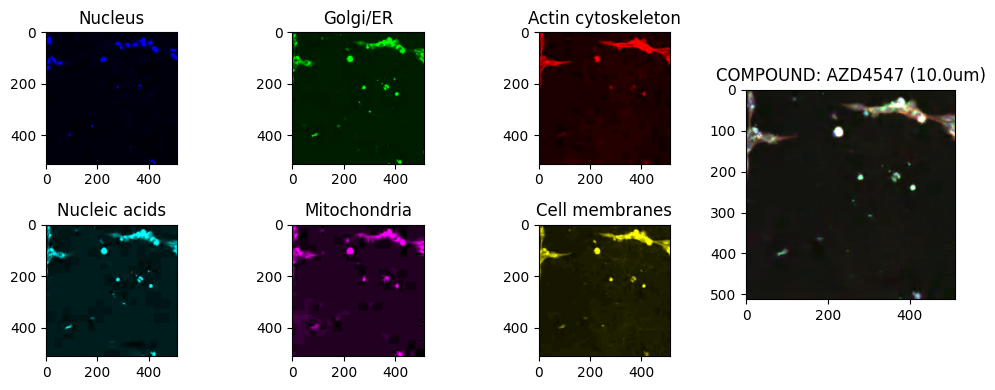

In [ ]:
# @title Qualitative analysis
# @markdown Look at each image in your team data by typing in its dataset_index (number between 0 and 222601). Get some intutition on what is the difference between the cells in the control vs. perturbed state

dataset_index = 131167 #@param {type:"number"}
show_dataset_image(dataset_index)


Measure the cells in your images. You can increase the max number of measured cells per image to improve confidence in your results

In [ ]:
# Apply ScaleFEx to all images in the dataset
all_sfex_features = []
max_cells_per_image = 50

print(f"Processing {len(rxrx3_team)} images...")

for idx, row in tqdm(rxrx3_team.iterrows(), total=len(rxrx3_team), desc="Processing images"):
    dataset_idx = row['dataset_index']

    # Get image data
    img_data = dataset.get_data(row=dataset_idx, col='images').T

    # Apply ScaleFEx to this image
    image_features = apply_scalefex_to_image(img_data, max_cells_per_image, roi=32, channel_names=channel_names)

    # Add metadata to each cell's features
    for features in image_features:
        features['dataset_index'] = dataset_idx
        features['Dose'] = row['Dose']
        features['treatment'] = row['treatment']
        all_sfex_features.append(features)

# Combine results
scalefex_team = pd.concat(all_sfex_features, ignore_index=True)
print(f"Processed {len(scalefex_team)} cells from {len(rxrx3_team)} images")
print(f"Shape: {scalefex_team.shape}")


In [ ]:
scalefex_team

SNR_intensityNucleus  MinRadius_shapeNucleus  MaxRadius_shapeNucleus  \
0               33.039151                      11                      12   
1                5.819330                      13                      18   
2                2.389566                      22                      24   
3                6.728449                      41                      44   
4               10.321846                      51                      52   
..                    ...                     ...                     ...   
275              2.404418                      25                      28   
276              2.702694                      27                      28   
277              4.805409                      19                      32   
278              3.097405                      41                      44   
279              4.903943                      24                      32   

     MeanRadius_shapeNucleus  Area_shapeNucleus  Perimeter_shapeNucleus  \
0                  10.881695                 93               33.798990   
1                  14.668929                169               49.213203   
2                  21.704807                370               73.355339   
3                  35.395871                984              155.154329   
4                  39.878267               1249              178.852814   
..                       ...                ...                     ...   
275                24.462677                470               82.669048   
276                25.606998                515               86.083261   
277                25.482389                510               86.870058   
278                31.209426                765              149.053824   
279                27.662555                601               93.355339   

     FormFactor_shapeNucleus  Solidity_shapeNucleus  Extent_shapeNucleus  \
0                   1.023023               0.948980             0.022705   
1                   0.876866               0.949438             0.041260   
2                   0.864068               0.948718             0.090332   
3                   0.513662               0.813223             0.240234   
4                   0.490660               0.832667             0.304932   
..                       ...                    ...                  ...   
275                 0.864215               0.969072             0.114746   
276                 0.873333               0.962617             0.125732   
277                 0.849258               0.967742             0.124512   
278                 0.432698               0.782209             0.186768   
279                 0.866575               0.952456             0.146729   

     Eccentricity_shapeNucleus  ...  \
0                     0.511833  ...   
1                     0.797359  ...   
2                     0.752392  ...   
3                     0.906242  ...   
4                     0.924598  ...   
..                         ...  ...   
275                   0.803208  ...   
276                   0.766356  ...   
277                   0.803585  ...   
278                   0.938981  ...   
279                   0.726186  ...   

     Correlation_Slope_Mitochondria_Cell membranes  \
0                                         3.073565   
1                                         3.049937   
2                                         2.909004   
3                                         3.260543   
4                                         3.312925   
..                                             ...   
275                                       2.511003   
276                                       1.768041   
277                                       3.182762   
278                                       2.294369   
279                                       2.167190   

     Correlation_Overlap_Mitochondria_Cell membranes  \
0                                           1.177430   
1                                   

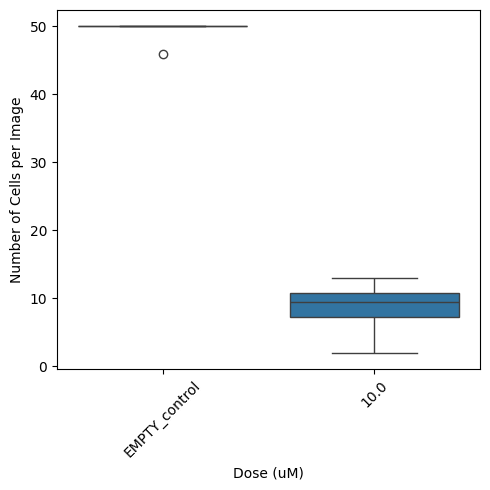

In [ ]:
# @title Quantitative Analysis
# @markdown Compare cellular features between control and perturbation conditions to identify treatment effects.

# Calculate cell counts per image
cell_counts = scalefex_team.groupby(['dataset_index', 'Dose']).size().reset_index(name='num_cells')

plt.figure(figsize=(5, 5))
sns.boxplot(data=cell_counts, x='Dose', y='num_cells')
plt.xlabel('Dose (uM)')
plt.ylabel('Number of Cells per Image')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
scalefex_team.columns

Index(['SNR_intensityNucleus', 'MinRadius_shapeNucleus',
       'MaxRadius_shapeNucleus', 'MeanRadius_shapeNucleus',
       'Area_shapeNucleus', 'Perimeter_shapeNucleus',
       'FormFactor_shapeNucleus', 'Solidity_shapeNucleus',
       'Extent_shapeNucleus', 'Eccentricity_shapeNucleus',
       ...
       'Correlation_Slope_Mitochondria_Cell membranes',
       'Correlation_Overlap_Mitochondria_Cell membranes',
       'Correlation_Mander1_Mitochondria_Cell membranes',
       'Correlation_Mander2_Mitochondria_Cell membranes',
       'Correlation_RWC1_Mitochondria_Cell membranes',
       'Correlation_RWC2_Mitochondria_Cell membranes', 'cell_id',
       'dataset_index', 'Dose', 'treatment'],
      dtype='object', length=2233)

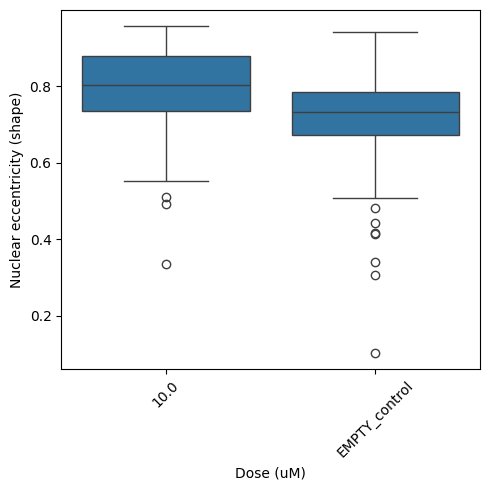

In [ ]:
# @markdown There are lots of single cell features you can inspect
plt.figure(figsize=(5, 5))
sns.boxplot(data=scalefex_team, x='Dose', y='Eccentricity_shapeNucleus')
plt.xlabel('Dose (uM)')
plt.ylabel('Nuclear eccentricity (shape)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### With your team, answer the following:
> 1. List potential pros and cons of cropping and featurizing cells, vs segmenting and featurizing cells
> 1.  The ScaleFEx paper summarizes each image as the mean of the features of all the cells for each image. What other ways could you summarize these features?
> 1. Compare contrast the efficiencies of the different approaches. In time, compute, memory.
> 1. [Coding question] Create a proxy for confluence. Does this correlate with the distance to control?
> 1. Do you expect the approaches we took to featurize these images would work well on images of tissue instead of cell culture? Why or why not?  
  >    a) Whole-image embedding from a pre-trained model
  >    b) Single-cell morphology feature extraction

